# Instanciando libs e chaves do search api

In [3]:
!pip install python-dotenv requests pandas tqdm

In [73]:
from dotenv import load_dotenv
import os

API_KEY = ""
CX = ""

assert API_KEY, "❌ Defina GOOGLE_API_KEY no seu .env"
assert CX,      "❌ Defina GOOGLE_CSE_CX no seu .env"

print("🔑 API_KEY e CX carregados com sucesso!")
# Suas credenciais para a API


🔑 API_KEY e CX carregados com sucesso!


# FUNCIONANDO O A MINERAÇÃO COM FILTRO POR ANO

In [99]:
import os, time, requests, pandas as pd

YEARS = ["2024","2023","2022","2021","2020","2019","2018","2017","2016","2015"]
DATE_RANGES = {
    "2024": ("2024-01-01", "2024-12-31"),
    "2023": ("2023-01-01", "2023-12-31"),
    "2022": ("2022-01-01", "2022-12-31"),
    "2021": ("2021-01-01", "2021-12-31"),
    "2020": ("2020-01-01", "2020-12-31"),
    "2019": ("2019-01-01", "2019-12-31"),
    "2018": ("2018-01-01", "2018-12-31"),
    "2017": ("2017-01-01", "2017-12-31"),
    "2016": ("2016-01-01", "2016-12-31"),
    "2015": ("2015-01-01", "2015-12-31"),
}
QUERIES_TEMPLATE = [
    'site:{host} ("big data" OR "data quality") AND test* after:{start} before:{end}'
    for (start,end) in DATE_RANGES.values()
]

SOURCES = {
    "Medium":   ("medium.com",   "custom_search_links_all_Medium.csv"),
    "LinkedIn": ("linkedin.com", "custom_search_links_all_LinkedIn.csv"),
    "DevTo":    ("dev.to",       "custom_search_links_all_DevTo.csv"),
}

PAGE_SIZE = 10
MAX_START = 100

def mine_source(host: str) -> pd.DataFrame:
    records = []
    seen = set()

    # vamos tentar duas “janelas” de 100: a primeira (0–99) e a segunda (100–199)
    offsets = [0, 100]

    for year_label, q_tmpl in zip(YEARS, QUERIES_TEMPLATE):
        query = q_tmpl.format(host=host,
                           start=DATE_RANGES[year_label][0],
                           end=  DATE_RANGES[year_label][1])
        print(f"[{host}] Year={year_label}  Query: {query}")

        for offset in offsets:
            for page in range(0, 10):  # 10 páginas de 10 em 10 = 100 resultados por janela
                start = offset + page * PAGE_SIZE + 1   # start=1,11,…,91 e depois 101,111,…,191
                print(f"  → start={start}")
                resp = requests.get(
                    "https://www.googleapis.com/customsearch/v1",
                    params={"q": query, "key": API_KEY, "cx": CX, "start": start}
                )
                if resp.status_code != 200:
                    print(f"     Erro {resp.status_code}, pulando this offset")
                    break

                items = resp.json().get("items", [])
                if not items:
                    break

                for item in items:
                    link = item.get("link")
                    if link not in seen:
                        seen.add(link)
                        records.append({"Link": link, "Year": year_label})

                # se menos que uma página cheia, não há próxima página nessa janela
                if len(items) < PAGE_SIZE:
                    break

                time.sleep(1)

    return pd.DataFrame.from_records(records, columns=["Link","Year"])


def main():
    for name, (host, fname) in SOURCES.items():
        print(f"\n=== Mining {name} ===")
        df = mine_source(host)
        df.to_csv(fname, index=False)
        print(f"{name}: {len(df)} links salvos em {fname}")

if __name__ == "__main__":
    main()



=== Mining Medium ===
[medium.com] Year=2024  Query: site:medium.com ("big data" OR "data quality") AND test* after:2024-01-01 before:2024-12-31
  → start=1
  → start=11
  → start=21
  → start=31
  → start=41
  → start=51
  → start=61
  → start=71
  → start=81
  → start=91
  → start=101
     Erro 400, pulando this offset
[medium.com] Year=2023  Query: site:medium.com ("big data" OR "data quality") AND test* after:2023-01-01 before:2023-12-31
  → start=1
  → start=11
  → start=21
  → start=31
  → start=41
  → start=51
  → start=61
  → start=71
  → start=81
  → start=91
  → start=101
     Erro 400, pulando this offset
[medium.com] Year=2022  Query: site:medium.com ("big data" OR "data quality") AND test* after:2022-01-01 before:2022-12-31
  → start=1
  → start=11
  → start=21
  → start=31
  → start=41
  → start=51
  → start=61
  → start=71
  → start=81
  → start=91
  → start=101
     Erro 400, pulando this offset
[medium.com] Year=2021  Query: site:medium.com ("big data" OR "data qualit

In [89]:
import os
import time
import requests
import pandas as pd


# Mapeamento de rótulos de ano e as queries correspondentes
YEARS = ["2024", "2023", "2022", "2021", "2020", "2019", "2018", "2017", "2016", "2015"]

QUERIES_TEMPLATE = [
    'site:{host} ("big data" OR "data quality") AND test* daterange:20240101-20241231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20230101-20231231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20220101-20221231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20210101-20211231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20200101-20201231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20190101-20191231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20180101-20181231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20170101-20171231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20160101-20161231',
    'site:{host} ("big data" OR "data quality") AND test* daterange:20150101-20151231',
]

SOURCES = {
    "Medium":   ("medium.com",   "custom_search_links_all_Medium.csv"),
    "LinkedIn": ("linkedin.com", "custom_search_links_all_LinkedIn.csv"),
    "DevTo":    ("dev.to",       "custom_search_links_all_DevTo.csv"),
}

# Número máximo de resultados a buscar por page-start
PAGE_SIZE = 10
MAX_START = 100

def mine_source(host: str) -> pd.DataFrame:
    records = []
    seen = set()     # conjunto para rastrear URLs já coletadas

    for year_label, q_tmpl in zip(YEARS, QUERIES_TEMPLATE):
        query = q_tmpl.format(host=host)
        print(f"[{host}] Year={year_label}  Query: {query}")

        for start in range(1, MAX_START + 1, PAGE_SIZE):
            resp = requests.get(
                "https://www.googleapis.com/customsearch/v1",
                params={"q": query, "key": API_KEY, "cx": CX, "start": start}
            )
            if resp.status_code != 200:
                print(f"  → Erro {resp.status_code}")
                break

            items = resp.json().get("items", [])
            if not items:
                break

            for item in items:
                link = item.get("link")
                # só registra se for um link novo
                if link not in seen:
                    seen.add(link)
                    records.append({
                        "Link": link,
                        "Year": year_label
                    })

            if len(items) < PAGE_SIZE:
                break

            time.sleep(1)

    return pd.DataFrame.from_records(records, columns=["Link", "Year"])


def main():
    for source_name, (host, filename) in SOURCES.items():
        print(f"\n=== Mining {source_name} ({host}) ===")
        df = mine_source(host)
        df.to_csv(filename, index=False)
        print(f"{source_name}: salvo {len(df)} rows em '{filename}'")


if __name__ == "__main__":
    main()


=== Mining Medium (medium.com) ===
[medium.com] Year=2024  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20240101-20241231
[medium.com] Year=2023  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20230101-20231231
[medium.com] Year=2022  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20220101-20221231
[medium.com] Year=2021  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20210101-20211231
[medium.com] Year=2020  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20200101-20201231
[medium.com] Year=2019  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20190101-20191231
[medium.com] Year=2018  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20180101-20181231
[medium.com] Year=2017  Query: site:medium.com ("big data" OR "data quality") AND test* daterange:20170101-20171231
[medium.com] Year=2016  Query: site:

# MINERANDO LINKS DO STACKOVERFLOW

In [31]:
pip install requests pandas

Note: you may need to restart the kernel to use updated packages.


In [134]:
import os, time, requests, pandas as pd
from datetime import datetime
from typing import List, Dict, Tuple

SITES = ["stackoverflow", "softwareengineering.stackexchange", "sqa.stackexchange"]

# Em vez de um único booleão, fazemos duas buscas: uma por cada frase
TERMS = [
    '"big data" test*',
    '"data quality" test*'
]

YEAR_RANGES: Dict[str, Tuple[str,str]] = {
    "2024": ("2024-01-01","2024-12-31"),
    "2023": ("2023-01-01","2023-12-31"),
    "2022": ("2022-01-01","2022-12-31"),
    "2021": ("2021-01-01","2021-12-31"),
    "2020": ("2020-01-01","2020-12-31"),
    "2019": ("2019-01-01","2019-12-31"),
    "2018": ("2018-01-01","2018-12-31"),
    "2017": ("2017-01-01","2017-12-31"),
    "2016": ("2016-01-01","2016-12-31"),
    "2015": ("2015-01-01","2015-12-31"),
}

MAX_PER_YEAR = 100
PAGE_SIZE    = 30
SLEEP_SEC    = 1
OUTPUT_CSV   = "custom_search_links_all_Stackoverflow.csv"

def to_ts(d: str) -> int:
    return int(datetime.strptime(d, "%Y-%m-%d").timestamp())

def search_advanced(q: str, site: str, fd: int, td: int) -> List[str]:
    url = "https://api.stackexchange.com/2.3/search/advanced"
    collected, page = [], 1
    while len(collected) < MAX_PER_YEAR:
        params = {
            "q": q, "site": site,
            "fromdate": fd, "todate": td,
            "pagesize": PAGE_SIZE, "page": page,
            "order": "desc", "sort": "activity"
        }
        if API_KEY:
            params["key"] = API_KEY
        r = requests.get(url, params=params); r.raise_for_status()
        items = r.json().get("items", [])
        if not items:
            break
        for it in items:
            link = it["link"]
            if link not in collected:
                collected.append(link)
                if len(collected) >= MAX_PER_YEAR:
                    break
        if len(items) < PAGE_SIZE:
            break
        page += 1
        time.sleep(SLEEP_SEC)
    return collected

def main():
    out = []
    for site in SITES:
        for year, (start, end) in YEAR_RANGES.items():
            fd, td = to_ts(start), to_ts(end)
            for term in TERMS:
                print(f"Searching '{term}' on {site} for {year}")
                links = search_advanced(term, site, fd, td)
                for link in links:
                    out.append({"Link": link, "Site": site, "Year": year})
    df = pd.DataFrame(out).drop_duplicates(subset=["Link","Year"])
    df.rename(columns={"Year":"Year"}, inplace=True)  # já está Year
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Done: {len(df)} rows ⇒ {df['Link'].nunique()} unique URLs")

if __name__ == "__main__":
    main()


Searching '"big data" test*' on stackoverflow for 2024
Searching '"data quality" test*' on stackoverflow for 2024
Searching '"big data" test*' on stackoverflow for 2023
Searching '"data quality" test*' on stackoverflow for 2023
Searching '"big data" test*' on stackoverflow for 2022
Searching '"data quality" test*' on stackoverflow for 2022
Searching '"big data" test*' on stackoverflow for 2021
Searching '"data quality" test*' on stackoverflow for 2021
Searching '"big data" test*' on stackoverflow for 2020
Searching '"data quality" test*' on stackoverflow for 2020
Searching '"big data" test*' on stackoverflow for 2019
Searching '"data quality" test*' on stackoverflow for 2019
Searching '"big data" test*' on stackoverflow for 2018
Searching '"data quality" test*' on stackoverflow for 2018
Searching '"big data" test*' on stackoverflow for 2017
Searching '"data quality" test*' on stackoverflow for 2017
Searching '"big data" test*' on stackoverflow for 2016
Searching '"data quality" test*' 

# Agregando os csvs e limpando os resultados

In [136]:
import pandas as pd
import glob
import os

def combine_and_dedup(
    pattern="custom_search_links_all_*.csv",
    out_combined="aggregates_links.csv",
    out_unique="aggregates_unique_links.csv"
):
    # 1) Encontra todos os CSVs que seguem o padrão
    files = glob.glob(pattern)
    if not files:
        print(f"❌ Nenhum arquivo encontrado com o padrão {pattern}")
        return

    # 2) Carrega cada um, marca a origem e acumula
    dfs = []
    for f in files:
        source = os.path.basename(f).replace("custom_search_links_all_", "").replace(".csv", "")
        df = pd.read_csv(f)
        df["Source"] = source
        dfs.append(df)

    # 3) Concatena todos
    combined = pd.concat(dfs, ignore_index=True)
    combined.to_csv(out_combined, index=False)
    print(f"✅ Arquivos ({len(files)}) combinados em '{out_combined}' — total de linhas: {len(combined)}")

    # 4) Remove duplicatas EXATAS de URL
    unique = combined.drop_duplicates(subset=["Link"])
    unique.to_csv(out_unique, index=False)
    print(f"✅ Duplicatas removidas em '{out_unique}' — total de links únicos: {len(unique)}")

if __name__ == "__main__":
    combine_and_dedup()


✅ Arquivos (4) combinados em 'aggregates_links.csv' — total de linhas: 3301
✅ Duplicatas removidas em 'aggregates_unique_links.csv' — total de links únicos: 3301


# Analise dos links duplicados individual

In [17]:
import pandas as pd
from urllib.parse import urlparse, urlunparse

# 1) Carregue o CSV (ajuste o caminho se precisar)
df = pd.read_csv("custom_search_links_all_LinkedIn.csv")

# 2) Limpeza básica
df["Link"] = df["Link"].str.strip()

# 3) Estatísticas exatas
total = len(df)
unique_exact = df["Link"].nunique()
dup_mask_exact = df["Link"].duplicated(keep=False)
dup_count_exact = dup_mask_exact.sum()

print(f"Total de linhas: {total}")
print(f"Links únicos (exatos): {unique_exact}")
print(f"Marcações de duplicados (exatas): {dup_count_exact}\n")

# 4) Mostrar alguns links não-duplicados
non_dups = df.loc[~dup_mask_exact, "Link"].drop_duplicates()
print("Exemplos de links não-duplicados (exatos):")
for link in non_dups.head(10):
    print(" •", link)

# 5) (Opcional) Normalização ignorando parâmetros de query
def normalize(url):
    p = urlparse(url)
    return urlunparse((p.scheme, p.netloc, p.path, "", "", ""))

df["Norm"] = df["Link"].apply(normalize)
unique_norm = df["Norm"].nunique()
dup_mask_norm = df["Norm"].duplicated(keep=False)
dup_count_norm = dup_mask_norm.sum()

print(f"\nDepois de normalizar (sem query params):")
print(f"Links únicos (normalizados): {unique_norm}")
print(f"Marcações de duplicados (normalizados): {dup_count_norm}")


Total de linhas: 600
Links únicos (exatos): 101
Marcações de duplicados (exatas): 599

Exemplos de links não-duplicados (exatos):
 • https://www.linkedin.com/posts/orchestra-go_snowflake-native-data-quality-and-anomaly-activity-7191094311499776000-s892

Depois de normalizar (sem query params):
Links únicos (normalizados): 101
Marcações de duplicados (normalizados): 599


In [19]:
import pandas as pd

df = pd.read_csv("custom_search_links_all_LinkedIn.csv")
df["Link"] = df["Link"].str.strip()

# Conta ocorrências de cada URL
counts = df["Link"].value_counts()

# Quantas URLs aparecem 1×, 2×, 3×, …
freq = counts.value_counts().sort_index()

print("Distribuição de quantas vezes cada link aparece:")
print(freq.to_string())

Distribuição de quantas vezes cada link aparece:
count
1     1
5     1
6    99


In [23]:
unique = df.drop_duplicates(subset=["Link"])
# unique.to_csv("devto_unique.csv", index=False)
# unique.to_csv("linkedin_unique.csv", index=False)
# unique.to_csv("medium_unique.csv", index=False)

# MINERANDO OS LINKS PARA O LDAVIS

In [27]:
pip install requests pandas beautifulsoup4 lxml

Note: you may need to restart the kernel to use updated packages.


In [151]:
"""
Este script lê links únicos de um CSV ("aggregates_unique_links.csv"),
acessa cada página, escaneia em busca de palavras-chave relacionadas
a ferramentas e métodos de teste, e grava um CSV com os resultados.
Logs métricas sobre tempo total, páginas processadas, erros, e contagens.
"""

import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import time
import logging
from datetime import timedelta

# ----- Configurações -----

INPUT_CSV       = "aggregates_unique_links.csv"
OUTPUT_CSV      = "posts_with_test_tools_and_methods.csv"
REQUEST_TIMEOUT = 10     # segundos
SLEEP_BETWEEN   = 1      # segundos entre requisições

TEST_TOOLS = [
    "JUnit", "Selenium", "TestNG", "Mockito", "Cucumber",
    "JUnit 5", "Appium", "Postman", "RestAssured",
    "Jest", "Mocha"
]
TEST_METHODS = [
    "Test-Driven Development", "Behavior-Driven Development",
    "Exploratory Testing", "Regression Testing", "Unit Testing",
    "Integration Testing", "Acceptance Testing", "Smoke Testing",
    "Load Testing"
]

# ----- Logging -----

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

# ----- Funções -----

def scan_page_for_keywords(url: str):
    """
    Acessa a página em 'url' e retorna duas listas:
    - ferramentas encontradas (de TEST_TOOLS)
    - métodos encontrados   (de TEST_METHODS)
    """
    tools_found = []
    methods_found = []
    try:
        start = time.perf_counter()
        resp = requests.get(url, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        html = resp.text
        duration = time.perf_counter() - start

        text = BeautifulSoup(html, "html.parser").get_text().lower()
        for tool in TEST_TOOLS:
            if re.search(r"\b" + re.escape(tool.lower()) + r"\b", text):
                tools_found.append(tool)
        for method in TEST_METHODS:
            if re.search(r"\b" + re.escape(method.lower()) + r"\b", text):
                methods_found.append(method)

        return tools_found, methods_found, duration, None

    except Exception as e:
        return [], [], 0.0, str(e)


def main():
    df_links = pd.read_csv(INPUT_CSV)
    if "Link" not in df_links.columns:
        raise KeyError(f"Coluna 'Link' não encontrada em {INPUT_CSV}")

    unique_links = df_links["Link"].dropna().unique().tolist()
    total = len(unique_links)

    logger.info(f"Começando mineração de {total} URLs")
    t0 = time.perf_counter()

    results = []
    stats = {
        "pages": 0,
        "errors": 0,
        "total_req_time": 0.0,
        "tools_hits": 0,
        "methods_hits": 0,
    }

    for idx, url in enumerate(unique_links, start=1):
        logger.info(f"[{idx}/{total}] Scanning: {url}")
        tools, methods, req_time, error = scan_page_for_keywords(url)
        stats["pages"] += 1
        stats["total_req_time"] += req_time

        if error:
            stats["errors"] += 1
            logger.warning(f"Erro ao acessar {url}: {error}")
        else:
            stats["tools_hits"] += len(tools)
            stats["methods_hits"] += len(methods)

        results.append({
            "Link":          url,
            "Tools_Found":   "; ".join(sorted(set(tools))),
            "Methods_Found": "; ".join(sorted(set(methods)))
        })

        time.sleep(SLEEP_BETWEEN)

    df_out = pd.DataFrame(results, columns=["Link", "Tools_Found", "Methods_Found"])
    df_out.to_csv(OUTPUT_CSV, index=False)

    elapsed = time.perf_counter() - t0
    logger.info("=== Resumo da mineração ===")
    logger.info(f"Total de páginas processadas: {stats['pages']}")
    logger.info(f"Erros de requisição: {stats['errors']}")
    logger.info(f"Tempo total de requisições: {stats['total_req_time']:.2f}s")
    logger.info(f"Tempo total (incluindo pauses): {timedelta(seconds=int(elapsed))}")
    logger.info(f"Média por página (req): {stats['total_req_time']/stats['pages']:.2f}s")
    logger.info(f"Total de hits em ferramentas: {stats['tools_hits']}")
    logger.info(f"Total de hits em métodos: {stats['methods_hits']}")
    logger.info(f"Resultados salvos em '{OUTPUT_CSV}'")

if __name__ == "__main__":
    main()


03:04:51 [INFO] Começando mineração de 3301 URLs
03:04:51 [INFO] [1/3301] Scanning: https://dev.to/aws-builders/deequ-your-datas-bff-372f
03:04:52 [INFO] [2/3301] Scanning: https://dev.to/ranjbaryshahab/improving-data-quality-in-clickhouse-databases-with-soda-4kp4
03:04:54 [INFO] [3/3301] Scanning: https://dev.to/chaets/an-end-to-end-guide-to-dbt-data-build-tool-with-a-use-case-example-18mk
03:04:56 [INFO] [4/3301] Scanning: https://dev.to/oyedeletemitope/10-reasons-for-flaky-tests-5a63
03:04:57 [INFO] [5/3301] Scanning: https://dev.to/voxel51/data-quality-the-hidden-driver-of-ai-success-2i63
03:04:59 [INFO] [6/3301] Scanning: https://dev.to/doriansabitov/optimizing-salesforce-data-integration-tools-and-best-practices-2g2i
03:05:01 [INFO] [7/3301] Scanning: https://dev.to/teamcity/introducing-the-new-teamcity-plugin-for-intellij-idea-197
03:05:03 [INFO] [8/3301] Scanning: https://dev.to/aws-builders/how-i-crushed-my-aws-certification-renewals-back-to-back-and-why-it-was-a-bad-idea-56fh

# LIMPANDO CSV COM LINKS FILTRADOS

In [153]:
import pandas as pd

# Configurações de arquivo
INPUT_CSV    = "posts_with_test_tools_and_methods.csv"
OUTPUT_CLEAN = "posts_with_tools_or_methods.csv"
OUTPUT_DROP  = "posts_without_tools_or_methods.csv"

def main():
    # 1) Carrega o CSV de resultados
    df = pd.read_csv(INPUT_CSV)

    # 2) Garante que strings vazias não sejam NaN
    df["Tools_Found"]   = df["Tools_Found"].fillna("").astype(str)
    df["Methods_Found"] = df["Methods_Found"].fillna("").astype(str)

    # 3) Cria máscara para linhas sem nenhuma palavra-chave
    mask_no_kw = (
        df["Tools_Found"].str.strip().eq("") &
        df["Methods_Found"].str.strip().eq("")
    )

    # 4) Separa DataFrames
    df_with_kw    = df[~mask_no_kw].copy()
    df_without_kw = df[mask_no_kw].copy()

    # 5) Salva arquivos
    df_with_kw.to_csv(OUTPUT_CLEAN, index=False)
    df_without_kw.to_csv(OUTPUT_DROP, index=False)

    # 6) Relatório final
    print(f"✅ Links com pelo menos um termo encontrado: {len(df_with_kw)} (salvo em '{OUTPUT_CLEAN}')")
    print(f"🔶 Links sem nenhum termo encontrado  : {len(df_without_kw)} (salvo em '{OUTPUT_DROP}')")

if __name__ == "__main__":
    main()

✅ Links com pelo menos um termo encontrado: 353 (salvo em 'posts_with_tools_or_methods.csv')
🔶 Links sem nenhum termo encontrado  : 2948 (salvo em 'posts_without_tools_or_methods.csv')


In [4]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
from datetime import datetime

input_csv = "aggregates_unique_links.csv"
output_csv = "extracted_posts_with_content.csv"

# Configurações
HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; BotMiner/1.0; +https://yourdomain.com/botinfo)"
}
MAX_RETRIES = 5
BACKOFF_FACTOR = 2  # Exponencial: 1s, 2s, 4s...

# Carregar os links
df_links = pd.read_csv(input_csv)
results = []

# Função de extração com controle de retries
def extract_title_and_text(url):
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            response = requests.get(url, headers=HEADERS, timeout=10)
            status = response.status_code

            if status == 200:
                soup = BeautifulSoup(response.text, "html.parser")
                title = soup.title.string.strip() if soup.title else "No Title"
                text = soup.get_text(separator='\n', strip=True)
                return title, text, status

            elif status == 429:
                wait_time = BACKOFF_FACTOR ** attempt
                print(f"[429] Too Many Requests. Esperando {wait_time}s (tentativa {attempt}/{MAX_RETRIES})")
                time.sleep(wait_time)
            else:
                print(f"[{status}] Falha ao acessar: {url}")
                return "No Title", "erro", status

        except Exception as e:
            print(f"[Erro] {e} ao acessar: {url}")
            return "No Title", "erro", None

    print(f"[Timeout] Excedidas as tentativas para: {url}")
    return "No Title", "erro", 429

# Iteração e coleta
start_time = time.time()
for idx, row in df_links.iterrows():
    url = row["Link"]
    print(f"\n[{idx+1}/{len(df_links)}] Acessando: {url}")
    title, content, status = extract_title_and_text(url)
    results.append({
        "Titulo": title,
        "Conteudo": content,
        "Status": status,
        "Link": url
    })

# Gerar CSV
df_results = pd.DataFrame(results)
df_results.to_csv(output_csv, index=False, encoding="utf-8")
elapsed = time.time() - start_time

print(f"\n✅ Processamento concluído em {elapsed:.2f} segundos.")
print(f"📄 Resultados salvos em '{output_csv}' com {len(df_results)} entradas.")



[1/3301] Acessando: https://dev.to/aws-builders/deequ-your-datas-bff-372f

[2/3301] Acessando: https://dev.to/ranjbaryshahab/improving-data-quality-in-clickhouse-databases-with-soda-4kp4

[3/3301] Acessando: https://dev.to/chaets/an-end-to-end-guide-to-dbt-data-build-tool-with-a-use-case-example-18mk

[4/3301] Acessando: https://dev.to/oyedeletemitope/10-reasons-for-flaky-tests-5a63

[5/3301] Acessando: https://dev.to/voxel51/data-quality-the-hidden-driver-of-ai-success-2i63

[6/3301] Acessando: https://dev.to/doriansabitov/optimizing-salesforce-data-integration-tools-and-best-practices-2g2i

[7/3301] Acessando: https://dev.to/teamcity/introducing-the-new-teamcity-plugin-for-intellij-idea-197

[8/3301] Acessando: https://dev.to/aws-builders/how-i-crushed-my-aws-certification-renewals-back-to-back-and-why-it-was-a-bad-idea-56fh

[9/3301] Acessando: https://dev.to/doriansabitov/how-to-simplify-large-salesforce-data-migration-52km

[10/3301] Acessando: https://dev.to/mainulspace/big-data

# PLOTANDO GRAFICOS

C:\Users\Icaro\AppData\Local\Temp\ipykernel_49296\102288790.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=labels)


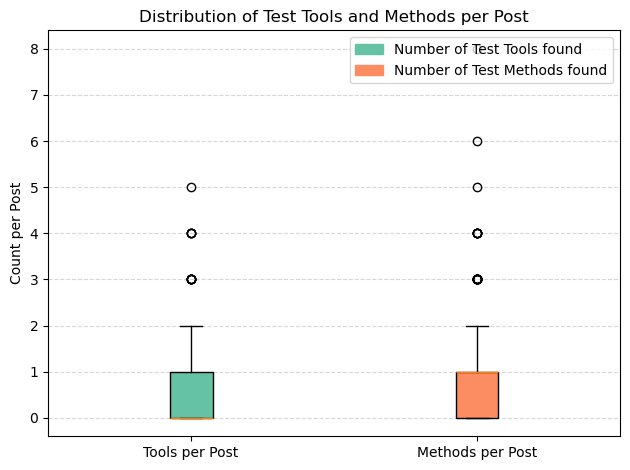

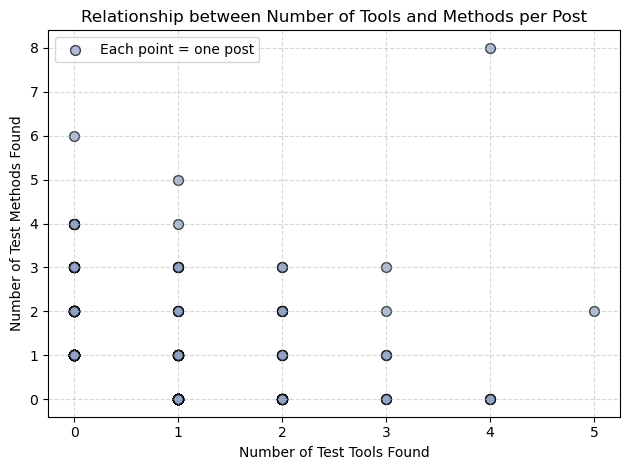

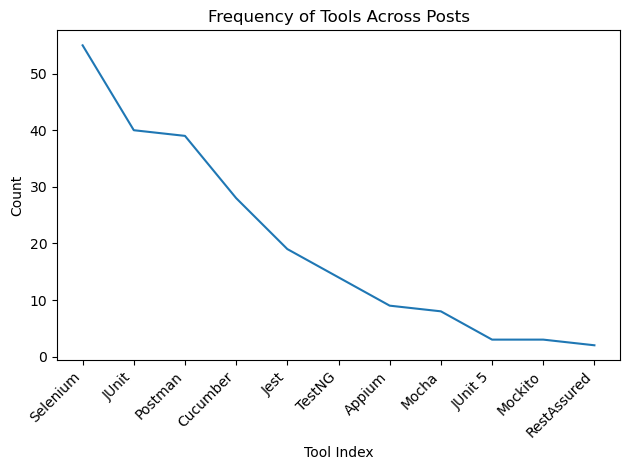

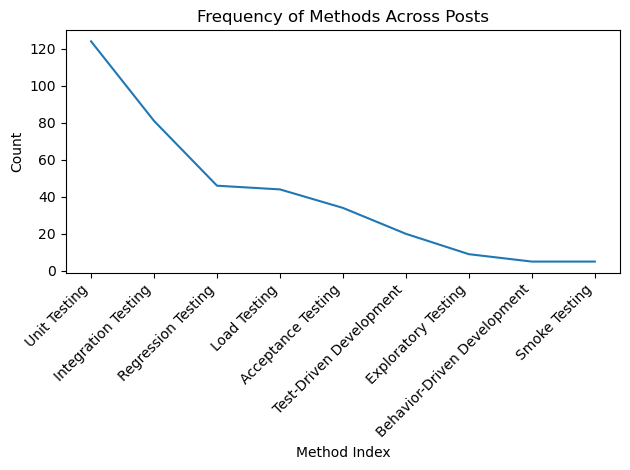

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Ajuste: Substitua o caminho pelo local correto do CSV
df = pd.read_csv("posts_with_tools_or_methods.csv")

# Limpeza e conversão de colunas para string
df["Tools_Found"] = df["Tools_Found"].fillna("").astype(str)
df["Methods_Found"] = df["Methods_Found"].fillna("").astype(str)

# Gerar colunas numéricas de contagem
df["num_tools"] = df["Tools_Found"].apply(lambda s: len([t for t in s.split("; ") if t.strip()]))
df["num_methods"] = df["Methods_Found"].apply(lambda s: len([m for m in s.split("; ") if m.strip()]))

# 1. Box‑plot com cores e legenda
fig, ax = plt.subplots()
data = [df["num_tools"], df["num_methods"]]
labels = ["Tools per Post", "Methods per Post"]
colors = ["#66c2a5", "#fc8d62"]

bp = ax.boxplot(data, patch_artist=True, labels=labels)

# aplica cores
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")

# adiciona legenda manual
legend_patches = [
    mpatches.Patch(color=colors[0], label="Number of Test Tools found"),
    mpatches.Patch(color=colors[1], label="Number of Test Methods found"),
]
ax.legend(handles=legend_patches, loc="upper right")

ax.set_title("Distribution of Test Tools and Methods per Post")
ax.set_ylabel("Count per Post")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Scatter plot com legenda
fig, ax = plt.subplots()
sc = ax.scatter(
    df["num_tools"],
    df["num_methods"],
    alpha=0.7,
    s=50,
    c="#8da0cb",
    edgecolor="black",
    label="Each point = one post"
)

ax.set_title("Relationship between Number of Tools and Methods per Post")
ax.set_xlabel("Number of Test Tools Found")
ax.set_ylabel("Number of Test Methods Found")
ax.legend(loc="upper left")
ax.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Line plot: frequência de cada ferramenta
tools_exploded = df["Tools_Found"].str.split("; ").explode().dropna()
tools_exploded = tools_exploded[tools_exploded != ""]
tool_counts = tools_exploded.value_counts()

plt.figure()
plt.plot(tool_counts.values)
plt.title("Frequency of Tools Across Posts")
plt.xlabel("Tool Index")
plt.ylabel("Count")
plt.xticks(range(len(tool_counts)), tool_counts.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Line plot: frequência de cada método
methods_exploded = df["Methods_Found"].str.split("; ").explode().dropna()
methods_exploded = methods_exploded[methods_exploded != ""]
method_counts = methods_exploded.value_counts()

plt.figure()
plt.plot(method_counts.values)
plt.title("Frequency of Methods Across Posts")
plt.xlabel("Method Index")
plt.ylabel("Count")
plt.xticks(range(len(method_counts)), method_counts.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()


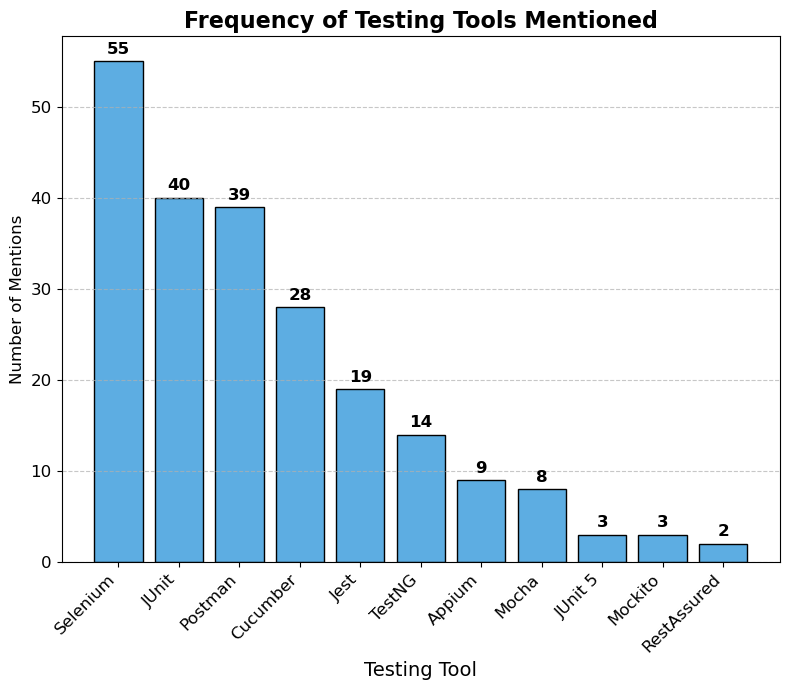

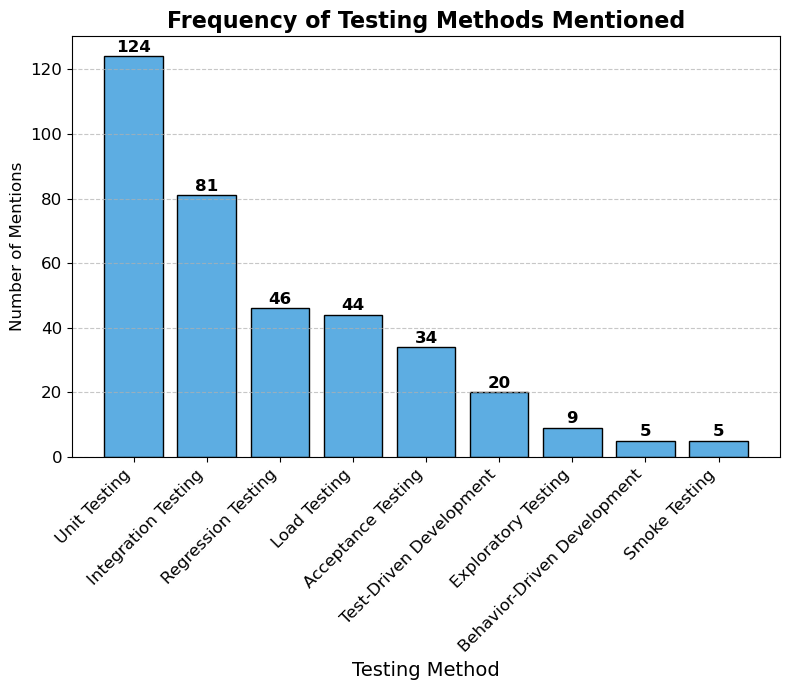

04:45:35 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04:45:35 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


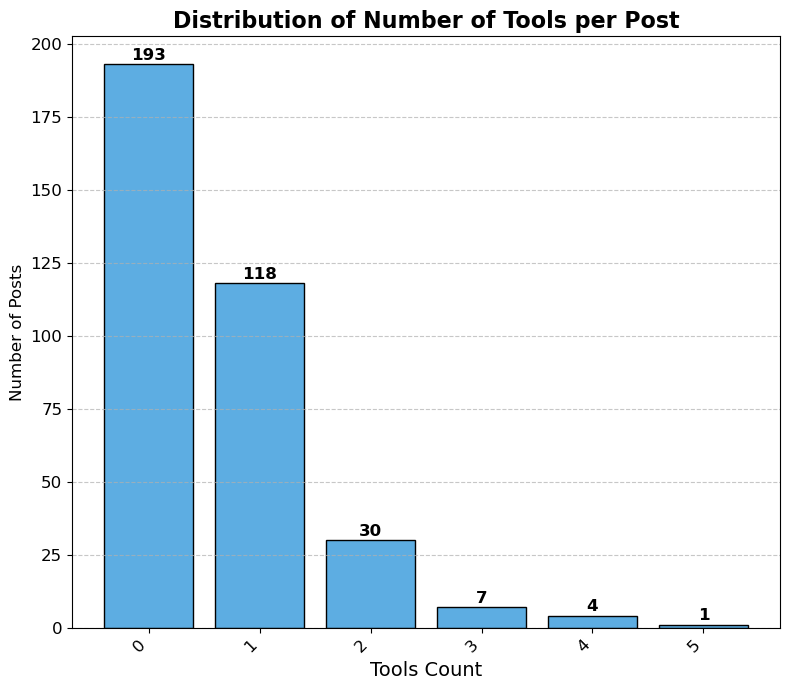

04:45:35 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
04:45:35 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


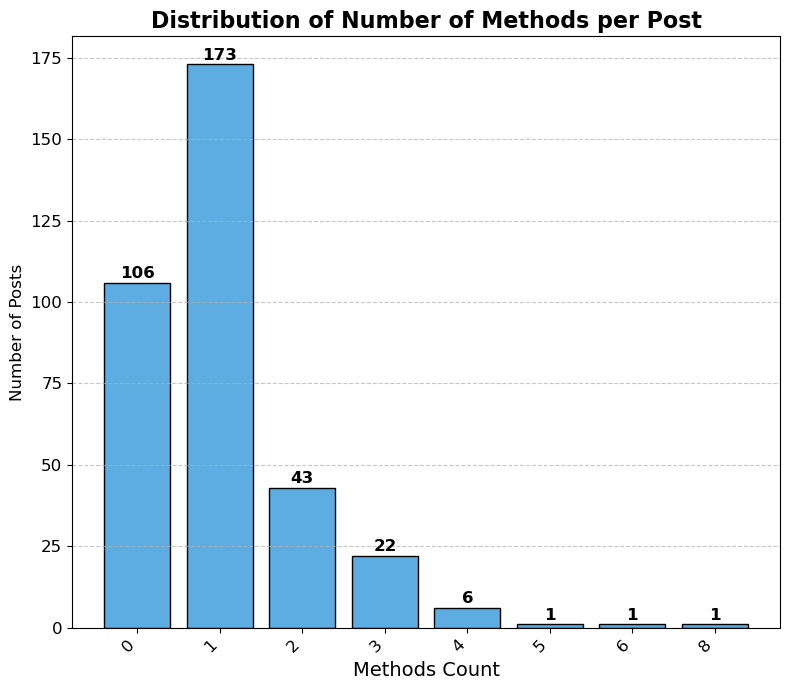

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar dados
df = pd.read_csv("posts_with_tools_or_methods.csv")

# 2. Limpeza e conversão de colunas
df["Tools_Found"] = df["Tools_Found"].fillna("").astype(str)
df["Methods_Found"] = df["Methods_Found"].fillna("").astype(str)

# 3. Contagem de ferramentas e métodos (explodindo listas)
tools = df["Tools_Found"].str.split("; ").explode()
tools = tools[tools != ""]
tool_counts = tools.value_counts()

methods = df["Methods_Found"].str.split("; ").explode()
methods = methods[methods != ""]
method_counts = methods.value_counts()

# 4. Contagem de número de itens por post
df["num_tools"] = df["Tools_Found"].apply(lambda s: len([t for t in s.split("; ") if t]))
df["num_methods"] = df["Methods_Found"].apply(lambda s: len([m for m in s.split("; ") if m]))

tools_per_post = df["num_tools"].value_counts().sort_index()
methods_per_post = df["num_methods"].value_counts().sort_index()

# Função para plotar barras com anotações
def bar_plot(counts, title, xlabel, ylabel):
    plt.figure(figsize=(8, 7))
    bars = plt.bar(counts.index.astype(str), counts.values, color="#5DADE2", edgecolor="black")
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                 ha="center", va="bottom", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

# 5. Plotar as quatro barras
bar_plot(tool_counts, "Frequency of Testing Tools Mentioned", "Testing Tool", "Number of Mentions")
bar_plot(method_counts, "Frequency of Testing Methods Mentioned", "Testing Method", "Number of Mentions")
bar_plot(tools_per_post, "Distribution of Number of Tools per Post", "Tools Count", "Number of Posts")
bar_plot(methods_per_post, "Distribution of Number of Methods per Post", "Methods Count", "Number of Posts")


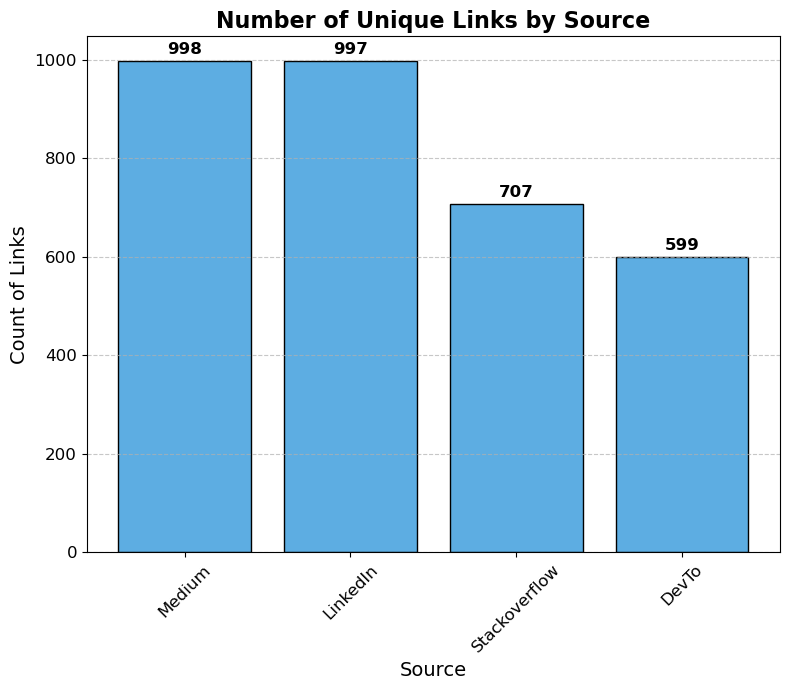

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar o CSV com os links únicos
df = pd.read_csv("aggregates_unique_links.csv")

# 2. Contar quantos links vieram de cada Source
source_counts = df["Source"].value_counts()

# 3. Plotar gráfico de barras
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(source_counts.index, source_counts.values,
              color="#5DADE2", edgecolor="black")

# 4. Anotar valores acima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.annotate(
        f"{h}",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 3),            # desloca o texto 3 pts para cima
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

# 5. Melhorar legibilidade
ax.set_title("Number of Unique Links by Source", fontsize=16, fontweight="bold")
ax.set_xlabel("Source", fontsize=14)
ax.set_ylabel("Count of Links", fontsize=14)
ax.tick_params(axis="x", rotation=45, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


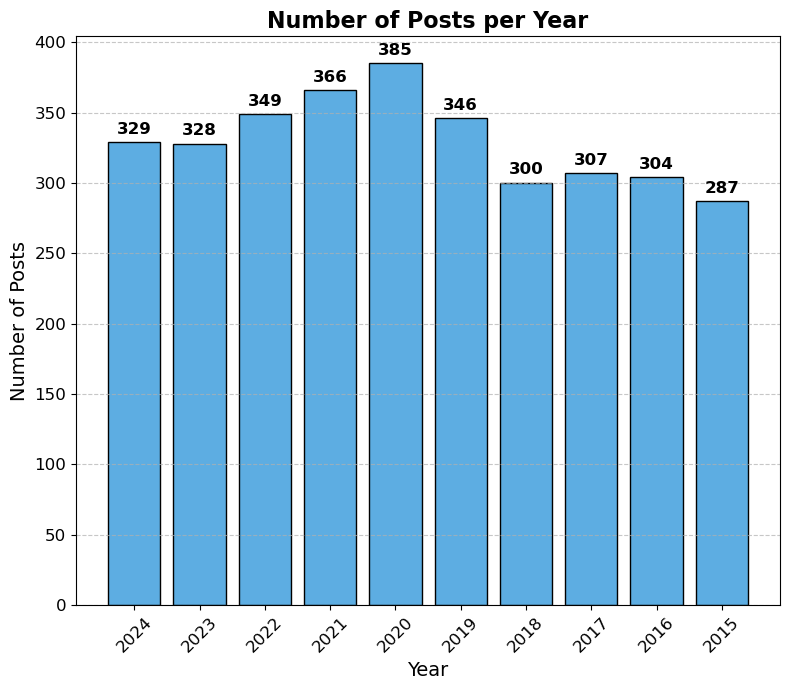

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar os dados
df = pd.read_csv("aggregates_unique_links.csv")

# 2. Converter a coluna Year (que vinha como float 2024.0 etc.) para string "2024"
df["Year"] = df["Year"].fillna(0).astype(int).astype(str)

# Se houver alguma linha cujo Year não seja um ano válido (ex.: "0"), você pode filtrá-la:
df = df[df["Year"].str.match(r"^\d{4}$")]

# 3. Contar quantos posts por ano
year_order = ["2024", "2023", "2022", "2021", "2020",
              "2019", "2018", "2017", "2016", "2015"]
counts = df["Year"].value_counts().reindex(year_order, fill_value=0)

# 4. Plotar o gráfico de barras
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(counts.index, counts.values,
              color="#5DADE2", edgecolor="black")

# 5. Anotar o valor exato acima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.annotate(
        f"{h}",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 4),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=12, fontweight="bold"
    )

# 6. Ajustes de estilo e labels
ax.set_title("Number of Posts per Year", fontsize=16, fontweight="bold")
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Posts", fontsize=14)
ax.tick_params(axis="x", rotation=45, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# MINERANDO TODO O CONTEUDO DOS LINKS PARA APLICAR CLUSTERIZAÇÃO

In [7]:
"""
Este script lê links únicos de um CSV ("aggregates_unique_links.csv"),
acessa cada página, extrai o texto completo e também escaneia por ferramentas/métodos.
Grava um CSV com os textos completos para análise posterior (ex: clusterização).
"""

import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import time
import logging
from datetime import timedelta

# ----- Configurações -----

INPUT_CSV       = "aggregates_unique_links.csv"
OUTPUT_CSV      = "posts_with_test_tools_and_methods_fulltext-v2.csv"
REQUEST_TIMEOUT = 10
SLEEP_BETWEEN   = 1

TEST_TOOLS = [
    "JUnit", "Selenium", "TestNG", "Mockito", "Cucumber",
    "JUnit 5", "Appium", "Postman", "RestAssured",
    "Jest", "Mocha"
]
TEST_METHODS = [
    "Test-Driven Development", "Behavior-Driven Development",
    "Exploratory Testing", "Regression Testing", "Unit Testing",
    "Integration Testing", "Acceptance Testing", "Smoke Testing",
    "Load Testing"
]

# ----- Logging -----

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

# ----- Funções -----

def scan_page_and_extract_text(url: str):
    """
    Acessa a URL e retorna:
    - ferramentas encontradas
    - métodos encontrados
    - texto limpo completo (sem HTML)
    - tempo de requisição
    - erro (se houver)
    """
    tools_found = []
    methods_found = []
    try:
        start = time.perf_counter()
        resp = requests.get(url, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        html = resp.text
        duration = time.perf_counter() - start

        soup = BeautifulSoup(html, "html.parser")
        full_text = soup.get_text(separator=" ", strip=True).lower()

        for tool in TEST_TOOLS:
            if re.search(r"\b" + re.escape(tool.lower()) + r"\b", full_text):
                tools_found.append(tool)
        for method in TEST_METHODS:
            if re.search(r"\b" + re.escape(method.lower()) + r"\b", full_text):
                methods_found.append(method)

        return tools_found, methods_found, full_text, duration, None

    except Exception as e:
        return [], [], "", 0.0, str(e)

def main():
    df_links = pd.read_csv(INPUT_CSV)
    if "Link" not in df_links.columns:
        raise KeyError(f"Coluna 'Link' não encontrada em {INPUT_CSV}")

    unique_links = df_links["Link"].dropna().unique().tolist()
    total = len(unique_links)

    logger.info(f"Começando mineração de {total} URLs")
    t0 = time.perf_counter()

    results = []
    stats = {
        "pages": 0,
        "errors": 0,
        "total_req_time": 0.0,
        "tools_hits": 0,
        "methods_hits": 0,
    }

    for idx, url in enumerate(unique_links, start=1):
        logger.info(f"[{idx}/{total}] Scanning: {url}")
        tools, methods, text, req_time, error = scan_page_and_extract_text(url)
        stats["pages"] += 1
        stats["total_req_time"] += req_time

        if error:
            stats["errors"] += 1
            logger.warning(f"Erro ao acessar {url}: {error}")
        else:
            stats["tools_hits"] += len(tools)
            stats["methods_hits"] += len(methods)

        results.append({
            "Link": url,
            "Tools_Found": "; ".join(sorted(set(tools))),
            "Methods_Found": "; ".join(sorted(set(methods))),
            "Post_Text": text
        })

        time.sleep(SLEEP_BETWEEN)

    df_out = pd.DataFrame(results, columns=["Link", "Tools_Found", "Methods_Found", "Post_Text"])
    df_out.to_csv(OUTPUT_CSV, index=False)

    elapsed = time.perf_counter() - t0
    logger.info("=== Resumo da mineração ===")
    logger.info(f"Total de páginas processadas: {stats['pages']}")
    logger.info(f"Erros de requisição: {stats['errors']}")
    logger.info(f"Tempo total de requisições: {stats['total_req_time']:.2f}s")
    logger.info(f"Tempo total (incluindo pauses): {timedelta(seconds=int(elapsed))}")
    logger.info(f"Média por página (req): {stats['total_req_time']/stats['pages']:.2f}s")
    logger.info(f"Total de hits em ferramentas: {stats['tools_hits']}")
    logger.info(f"Total de hits em métodos: {stats['methods_hits']}")
    logger.info(f"Resultados salvos em '{OUTPUT_CSV}'")

if __name__ == "__main__":
    main()


19:36:16 [INFO] Começando mineração de 3301 URLs
19:36:16 [INFO] [1/3301] Scanning: https://dev.to/aws-builders/deequ-your-datas-bff-372f
19:36:17 [INFO] [2/3301] Scanning: https://dev.to/ranjbaryshahab/improving-data-quality-in-clickhouse-databases-with-soda-4kp4
19:36:19 [INFO] [3/3301] Scanning: https://dev.to/chaets/an-end-to-end-guide-to-dbt-data-build-tool-with-a-use-case-example-18mk
19:36:20 [INFO] [4/3301] Scanning: https://dev.to/oyedeletemitope/10-reasons-for-flaky-tests-5a63
19:36:21 [INFO] [5/3301] Scanning: https://dev.to/voxel51/data-quality-the-hidden-driver-of-ai-success-2i63
19:36:22 [INFO] [6/3301] Scanning: https://dev.to/doriansabitov/optimizing-salesforce-data-integration-tools-and-best-practices-2g2i
19:36:24 [INFO] [7/3301] Scanning: https://dev.to/teamcity/introducing-the-new-teamcity-plugin-for-intellij-idea-197
19:36:25 [INFO] [8/3301] Scanning: https://dev.to/aws-builders/how-i-crushed-my-aws-certification-renewals-back-to-back-and-why-it-was-a-bad-idea-56fh

### 21:04:55 [INFO] === Resumo da Mineração ===
### 21:04:55 [INFO] Total de páginas processadas: 3301
### 21:04:55 [INFO] Erros de requisição: 715
### 21:04:55 [INFO] Tempo total de requisições: 1840.96s
### 21:04:55 [INFO] Tempo total (incluindo pauses): 1:28:38
### 21:04:55 [INFO] Média por página (req): 0.56s
### 21:04:55 [INFO] Total de hits em ferramentas: 185
### 21:04:55 [INFO] Total de hits em métodos: 355
### 21:04:55 [INFO] Resultados salvos em 'posts_with_test_tools_and_methods_fulltext-v2.csv'

## Mantivemos exatamente essas listas de palavras-chave por três motivos principais:

### Cobertura dos Frameworks e Métodos Mais Citados
– As ferramentas em TEST_TOOLS (JUnit, Selenium, TestNG, etc.) e os métodos em TEST_METHODS (TDD, BDD, Exploratory Testing etc.) são, segundo nossa revisão de literatura e inspeções iniciais de posts, os que aparecem com muito mais frequência em discussões de engenharia de testes — incluindo aquelas voltadas a Big Data.
– Elas formam um “conjunto semente” que garante que, ao menos, os casos de uso mais estabelecidos (unitários, integração, aceitação, carga, etc.) sejam capturados de imediato.

### Base para Descoberta de Novos Termos via Clusterização
– Mantendo essas palavras como anchors, podemos depois extrair todo o texto dos posts e aplicar técnicas de embedding + clustering.
– Os clusters que contiverem termos próximos a “JUnit”, “Selenium” ou a expressões como “Test-Driven Development” indicarão grupos semânticos onde novos nomes de ferramentas/métodos podem emergir.

### Consistência com Estudos Pré-existentes
– Elas são amplamente reconhecidas em artigos de validação de qualidade e testes de Big Data (por exemplo, Gao et al. 2016 e Arshad et al. 2021 destacam frameworks como JUnit ou métodos exploratórios).
– Ao começar com um vocabulário consensual, reduzimos o ruído de termos irrelevantes e focamos nossa análise inicial em tecnologias efetivamente empregadas pela comunidade.

Dessa forma, essas listas funcionam como garantia de que nossa primeira mineração não deixe de capturar as ferramentas e práticas mais consolidadas, ao mesmo tempo em que preparam o terreno para, em etapas subsequentes, descobrir termos inéditos de forma automática.

# KMeans

In [111]:
!pip install -U sentence-transformers
!pip install ipywidgets
!pip install hf_xet

22:22:46 [INFO] Loaded 3301 documents
22:22:46 [INFO] After loading data — Memory usage: 987.3 MB
22:22:46 [INFO] Use pytorch device_name: cpu
22:22:46 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

22:26:13 [INFO] Embeddings generated in 204.0s
22:26:13 [INFO] After generating embeddings — Memory usage: 1051.3 MB
22:26:13 [INFO] Testing KMeans with k=5
22:26:15 [INFO]  → silhouette_score=0.340
22:26:15 [INFO] Testing KMeans with k=10
22:26:18 [INFO]  → silhouette_score=0.341
22:26:18 [INFO] Testing KMeans with k=15
22:26:22 [INFO]  → silhouette_score=0.346
22:26:22 [INFO] Testing KMeans with k=20
22:26:27 [INFO]  → silhouette_score=0.344
22:26:27 [INFO] BEST k=15 with silhouette=0.346
22:26:31 [INFO] Final KMeans (k=15) in 3.65s
22:26:31 [INFO] After clustering — Memory usage: 1051.3 MB
22:26:32 [INFO] Clusters saved to posts_with_clusters.csv
22:26:32 [INFO] PCA 2D done in 0.04s
22:26:32 [INFO] After PCA — Memory usage: 1051.3 MB


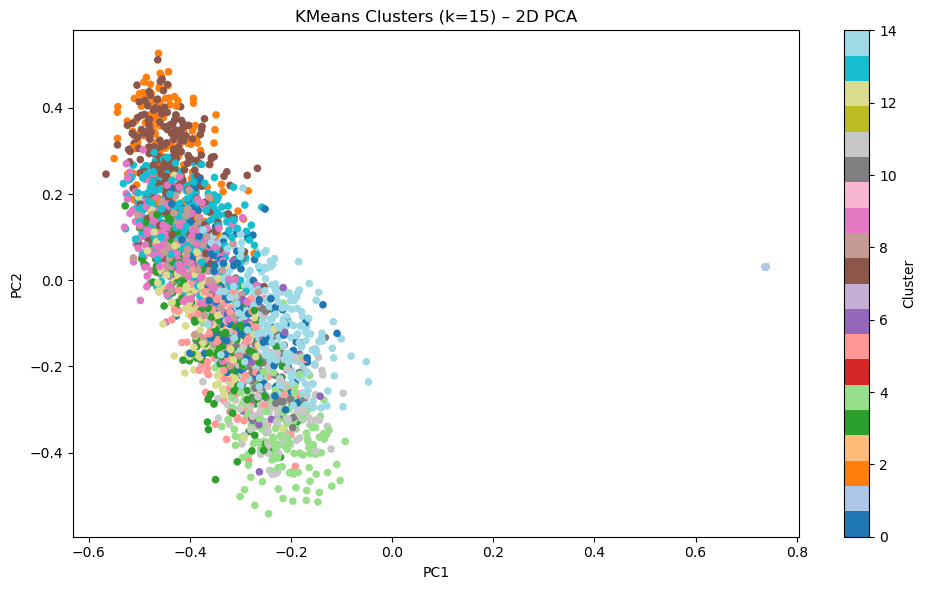

22:26:33 [INFO] Saved cluster_viz.png
22:26:33 [INFO] Extracting top terms per cluster via TF-IDF
22:26:38 [INFO] Cluster 0: 150 documents
22:26:38 [INFO]  → Top terms: learning(0.10), machine(0.09), model(0.08), ai(0.08), models(0.05), training(0.05), intelligence(0.04), ml(0.04), deep(0.04), dev(0.04)
22:26:38 [INFO] Cluster 1: 1054 documents
22:26:38 [INFO]  → Top terms: 𝐃𝐚𝐭𝐚(0.00), ensuing(0.00), enterprises(0.00), enterprise(0.00), entering(0.00), entered(0.00), enter(0.00), entender(0.00), entails(0.00), entail(0.00)
22:26:38 [INFO] Cluster 2: 155 documents
22:26:39 [INFO]  → Top terms: quality(0.26), contribution(0.19), contributions(0.07), policy(0.06), like(0.06), linkedin(0.06), report(0.06), cancel(0.05), add(0.05), copy(0.05)
22:26:39 [INFO] Cluster 3: 193 documents
22:26:39 [INFO]  → Top terms: testing(0.17), dbt(0.06), quality(0.05), etl(0.04), unit(0.04), sign(0.04), automation(0.04), software(0.04), like(0.03), pipeline(0.03)
22:26:39 [INFO] Cluster 4: 170 documents
22:

In [38]:
import time
import logging
import psutil
import os, time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer

start_time_km =  time.time()
print("Processing time...")

# ── Logging Setup ─────────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

def log_memory(msg: str):
    mem = psutil.Process(os.getpid()).memory_info().rss / (1024**2)  # in MB
    logger.info(f"{msg} — Memory usage: {mem:.1f} MB")

# ── Config ──────────────────────────────────────────────────────────────────────
INPUT_CSV      = "posts_with_test_tools_and_methods_fulltext-v2.csv"
OUTPUT_CSV     = "posts_with_clusters_KMEANS.csv"
EMBED_MODEL    = "all-MiniLM-L6-v2"
CLUSTER_TRIES  = [5, 10, 15, 20]
STOPWORDS      = ENGLISH_STOP_WORDS.union({"big", "data", "test", "tests"})

# ── Load Data ───────────────────────────────────────────────────────────────────
df = pd.read_csv(INPUT_CSV)
if "Post_Text" not in df.columns:
    raise KeyError(f"Column 'Post_Text' not in {INPUT_CSV}; found: {df.columns.tolist()}")

texts = df["Post_Text"].fillna("").tolist()
logger.info(f"Loaded {len(texts)} documents")
log_memory("After loading data")

# ── Embedding ──────────────────────────────────────────────────────────────────
model = SentenceTransformer(EMBED_MODEL)
start = time.perf_counter()
embeddings = model.encode(texts, batch_size=32, show_progress_bar=True)
logger.info(f"Embeddings generated in {time.perf_counter()-start:.1f}s")
log_memory("After generating embeddings")

# ── Silhouette-driven choice of K ────────────────────────────────────────────────
best_k, best_score = None, -1
for k in CLUSTER_TRIES:
    logger.info(f"Testing KMeans with k={k}")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    logger.info(f" → silhouette_score={score:.3f}")
    if score > best_score:
        best_k, best_score = k, score

logger.info(f"BEST k={best_k} with silhouette={best_score:.3f}")

time_km = time.time() - start_time_km

# ── Final Clustering ─────────────────────────────────────────────────────────────
start = time.perf_counter()
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
df["Cluster"] = kmeans.fit_predict(embeddings)
logger.info(f"Final KMeans (k={best_k}) in {time.perf_counter()-start:.2f}s")
log_memory("After clustering")

df.to_csv(OUTPUT_CSV, index=False)
logger.info(f"Clusters saved to {OUTPUT_CSV}")

# ── PCA for 2D Viz ──────────────────────────────────────────────────────────────
start = time.perf_counter()
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(embeddings)
logger.info(f"PCA 2D done in {time.perf_counter()-start:.2f}s")
log_memory("After PCA")

plt.figure(figsize=(10,6))
scatter = plt.scatter(coords[:,0], coords[:,1], c=df["Cluster"], s=20, cmap="tab20")
plt.title(f"KMeans Clusters (k={best_k}) – 2D PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.savefig("cluster_viz_KMEANS.png")
plt.show()
logger.info("Saved cluster_viz_KMEANS.png")

# ── Map step: gather docs per cluster ─────────────────────────────────────────────
cluster_docs = (
    df.assign(Post_Text=df["Post_Text"].fillna(""))
      .groupby("Cluster")["Post_Text"]
      .agg(list)
)

# ── Reduce step: extract top terms via TF-IDF ────────────────────────────────────
logger.info("Extracting top terms per cluster via TF-IDF")
vectorizer = TfidfVectorizer(
    stop_words=list(STOPWORDS),  # agora é uma lista, tipo aceito
    max_df=0.8,
    min_df=5
)
corpus = df["Post_Text"].fillna("").tolist()
tfidf = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

for c, texts_in_c in cluster_docs.items():
    logger.info(f"Cluster {c}: {len(texts_in_c)} documents")
    tfidf_c = vectorizer.transform(texts_in_c)
    # average tfidf score per term
    avg_scores = tfidf_c.mean(axis=0).A1
    top_idxs = avg_scores.argsort()[::-1][:10]
    top_terms = [feature_names[i] for i in top_idxs]
    top_scores = avg_scores[top_idxs]
    logger.info(f" → Top terms: " + ", ".join(f"{t}({s:.2f})" for t,s in zip(top_terms, top_scores)))

log_memory("End of clustering pipeline")
print("Processing time (s) = %3.3f s" % (time_km))

#### 22:22:46 [INFO] Loaded 3301 documents
#### 22:22:46 [INFO] After loading data — Memory usage: 987.3 MB
#### 22:22:46 [INFO] Use pytorch device_name: cpu
#### 22:22:46 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Error displaying widget
#### 22:26:13 [INFO] Embeddings generated in 204.0s
#### 22:26:13 [INFO] After generating embeddings — Memory usage: 1051.3 MB
#### 22:26:13 [INFO] Testing KMeans with k=5
#### 22:26:15 [INFO]  → silhouette_score=0.340
#### 22:26:15 [INFO] Testing KMeans with k=10
#### 22:26:18 [INFO]  → silhouette_score=0.341
#### 22:26:18 [INFO] Testing KMeans with k=15
#### 22:26:22 [INFO]  → silhouette_score=0.346
#### 22:26:22 [INFO] Testing KMeans with k=20
#### 22:26:27 [INFO]  → silhouette_score=0.344
#### 22:26:27 [INFO] BEST k=15 with silhouette=0.346
#### 22:26:31 [INFO] Final KMeans (k=15) in 3.65s
#### 22:26:31 [INFO] After clustering — Memory usage: 1051.3 MB
#### 22:26:32 [INFO] Clusters saved to posts_with_clusters.csv
#### 22:26:32 [INFO] PCA 2D done in 0.04s
#### 22:26:32 [INFO] After PCA — Memory usage: 1051.3 MB
#### 22:26:33 [INFO] Saved cluster_viz.png
#### 22:26:33 [INFO] Extracting top terms per cluster via TF-IDF
#### 22:26:38 [INFO] Cluster 0: 150 documents
#### 22:26:38 [INFO]  → Top terms: learning(0.10), machine(0.09), model(0.08), ai(0.08), models(0.05), training(0.05), intelligence(0.04), ml(0.04), deep(0.04), dev(0.04)
#### 22:26:38 [INFO] Cluster 1: 1054 documents
#### 22:26:38 [INFO]  → Top terms: 𝐃𝐚𝐭𝐚(0.00), ensuing(0.00), enterprises(0.00), enterprise(0.00), entering(0.00), entered(0.00), enter(0.00), entender(0.00), entails(0.00), entail(0.00)
#### 22:26:38 [INFO] Cluster 2: 155 documents
#### 22:26:39 [INFO]  → Top terms: quality(0.26), contribution(0.19), contributions(0.07), policy(0.06), like(0.06), linkedin(0.06), report(0.06), cancel(0.05), add(0.05), copy(0.05)
#### 22:26:39 [INFO] Cluster 3: 193 documents
#### 22:26:39 [INFO]  → Top terms: testing(0.17), dbt(0.06), quality(0.05), etl(0.04), unit(0.04), sign(0.04), automation(0.04), software(0.04), like(0.03), pipeline(0.03)
#### 22:26:39 [INFO] Cluster 4: 170 documents
#### 22:26:40 [INFO]  → Top terms: dev(0.14), fullscreen(0.11), mode(0.10), comment(0.07), like(0.07), exit(0.06), enter(0.05), js(0.04), hide(0.04), code(0.04)
#### 22:26:40 [INFO] Cluster 5: 156 documents
#### 22:26:40 [INFO]  → Top terms: aws(0.14), dev(0.08), cloud(0.06), fullscreen(0.05), s3(0.05), mode(0.05), like(0.04), azure(0.04), comment(0.04), service(0.03)
#### 22:26:40 [INFO] Cluster 6: 36 documents
#### 22:26:40 [INFO]  → Top terms: scichart(0.28), chart(0.18), charts(0.13), js(0.10), javascript(0.09), dev(0.08), android(0.06), fps(0.05), wpf(0.05), 3d(0.04)
#### 22:26:40 [INFO] Cluster 7: 216 documents
#### 22:26:40 [INFO]  → Top terms: quality(0.21), expectations(0.06), checks(0.05), sign(0.04), soda(0.04), validation(0.04), column(0.03), observability(0.03), values(0.03), medium(0.03)
#### 22:26:40 [INFO] Cluster 8: 112 documents
#### 22:26:41 [INFO]  → Top terms: science(0.10), learning(0.06), exam(0.06), analytics(0.05), sign(0.04), machine(0.04), scientists(0.04), scientist(0.04), business(0.04), aws(0.03)
#### 22:26:41 [INFO] Cluster 9: 227 documents
#### 22:26:41 [INFO]  → Top terms: dbt(0.06), pipeline(0.04), analytics(0.03), quality(0.03), dev(0.03), sql(0.03), use(0.03), time(0.03), sign(0.03), table(0.03)
#### 22:26:41 [INFO] Cluster 10: 62 documents
#### 22:26:41 [INFO]  → Top terms: jobs(0.41), policy(0.16), join(0.14), ago(0.13), linkedin(0.12), sign(0.12), assurance(0.12), engineer(0.12), analyst(0.11), clear(0.10)
#### 22:26:41 [INFO] Cluster 11: 141 documents
#### 22:26:42 [INFO]  → Top terms: dev(0.11), comment(0.10), like(0.10), code(0.07), hide(0.05), software(0.05), link(0.05), dropdown(0.05), fullscreen(0.05), menu(0.05)
#### 22:26:42 [INFO] Cluster 12: 130 documents
#### 22:26:42 [INFO]  → Top terms: spark(0.25), apache(0.07), hadoop(0.07), pyspark(0.07), cluster(0.05), scala(0.04), python(0.04), hive(0.04), file(0.03), sign(0.03)
#### 22:26:42 [INFO] Cluster 13: 254 documents
#### 22:26:43 [INFO]  → Top terms: analytics(0.06), policy(0.05), business(0.05), sign(0.05), ai(0.04), linkedin(0.04), join(0.04), like(0.04), learning(0.03), time(0.03)
#### 22:26:43 [INFO] Cluster 14: 245 documents
#### 22:26:43 [INFO]  → Top terms: sign(0.05), policy(0.04), like(0.04), people(0.04), comment(0.03), linkedin(0.03), join(0.03), new(0.03), business(0.03), time(0.02)
#### 22:26:43 [INFO] End of clustering pipeline — Memory usage: 1017.8 MB

### I’ve added a complete “Cell 2” implementation that:

1. Loads your scraped post content

2. Generates SBERT embeddings in Map-Reduce style (batch-wise MiniBatchKMeans)

3. Performs a final reduce-phase KMeans on aggregated centroids

4. Runs a DBSCAN clustering pass for comparison

5. Logs every major step, batch, and evaluation metric (silhouette scores)

6. Saves per-post cluster assignments to CSV

This gives you two clustering outputs and plenty of logs to compare KMeans vs DBSCAN performance. Let me know if you'd like adjustments or help visualizing the clusters!

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
Capaz de identificar clusters de forma arbitrária e detectar outliers.

Útil quando os dados possuem regiões densas com formatos variados.

Referência: Ester et al., 1996.

# Bisecting k-means
Bisecting k-means is a kind of hierarchical clustering using a divisive (or “top-down”) approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy. Bisecting K-means can often be much faster than regular K-means, but it will generally produce a different clustering.

In [5]:
pip install pyspark

  Using cached pyspark-4.0.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)
Note: you may need to restart the kernel to use updated packages.


Processing time...


23:03:41 [INFO] Loaded 3301 documents
23:03:41 [INFO] After loading data — Memory usage: 890.6 MB
23:03:41 [INFO] Use pytorch device_name: cpu
23:03:41 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

23:07:29 [INFO] Embeddings generated in 225.2s
23:07:29 [INFO] After generating embeddings — Memory usage: 1037.1 MB
23:07:29 [INFO] Testing B-KMeans with k=5
23:07:30 [INFO]  → silhouette_score=0.340
23:07:30 [INFO] Testing B-KMeans with k=10
23:07:33 [INFO]  → silhouette_score=0.339
23:07:33 [INFO] Testing B-KMeans with k=15
23:07:37 [INFO]  → silhouette_score=0.338
23:07:37 [INFO] Testing B-KMeans with k=20
23:07:41 [INFO]  → silhouette_score=0.339
23:07:41 [INFO] BEST k=5 with silhouette=0.340
23:07:43 [INFO] Final B-KMeans (k=5) in 1.14s
23:07:43 [INFO] After clustering — Memory usage: 1037.3 MB
23:07:43 [INFO] Clusters saved to posts_with_clusters_B-KMEANS.csv
23:07:44 [INFO] PCA 2D done in 0.04s
23:07:44 [INFO] After PCA — Memory usage: 1037.3 MB


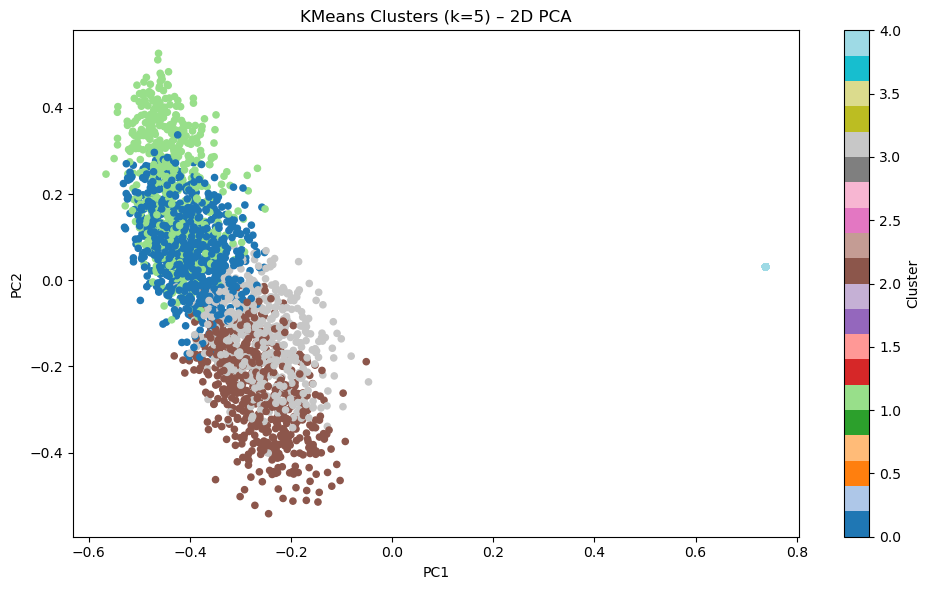

23:07:45 [INFO] Saved cluster_viz_B-KMEANS.png
23:07:45 [INFO] Extracting top terms per cluster via TF-IDF
23:07:50 [INFO] Cluster 0: 703 documents
23:07:52 [INFO]  → Top terms: analytics(0.04), spark(0.04), sign(0.04), science(0.03), learning(0.03), business(0.03), like(0.03), ai(0.03), use(0.03), machine(0.03)
23:07:52 [INFO] Cluster 1: 517 documents
23:07:53 [INFO]  → Top terms: quality(0.18), contribution(0.06), testing(0.06), dbt(0.04), sign(0.04), checks(0.04), expectations(0.04), like(0.04), validation(0.03), issues(0.03)
23:07:53 [INFO] Cluster 2: 561 documents
23:07:54 [INFO]  → Top terms: dev(0.10), fullscreen(0.07), mode(0.06), like(0.05), comment(0.05), code(0.04), software(0.03), exit(0.03), use(0.03), enter(0.03)
23:07:54 [INFO] Cluster 3: 466 documents
23:07:55 [INFO]  → Top terms: jobs(0.06), sign(0.05), policy(0.05), linkedin(0.04), join(0.04), like(0.04), comment(0.04), learning(0.03), ai(0.03), software(0.03)
23:07:55 [INFO] Cluster 4: 1054 documents
23:07:55 [INFO] 

Processing time (s) = 240.984 s


In [5]:
import time
import logging
import psutil
import os, time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import BisectingKMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer

start_time_bk = time.time()
print("Processing time...")

# ── Logging Setup ─────────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

def log_memory(msg: str):
    mem = psutil.Process(os.getpid()).memory_info().rss / (1024**2)  # in MB
    logger.info(f"{msg} — Memory usage: {mem:.1f} MB")

# ── Config ──────────────────────────────────────────────────────────────────────
INPUT_CSV      = "posts_with_test_tools_and_methods_fulltext-v2.csv"
OUTPUT_CSV     = "posts_with_clusters_B-KMEANS.csv"
EMBED_MODEL    = "all-MiniLM-L6-v2"
CLUSTER_TRIES  = [5, 10, 15, 20]
STOPWORDS      = ENGLISH_STOP_WORDS.union({"big", "data", "test", "tests"})

# ── Load Data ───────────────────────────────────────────────────────────────────
df = pd.read_csv(INPUT_CSV)
if "Post_Text" not in df.columns:
    raise KeyError(f"Column 'Post_Text' not in {INPUT_CSV}; found: {df.columns.tolist()}")

texts = df["Post_Text"].fillna("").tolist()
logger.info(f"Loaded {len(texts)} documents")
log_memory("After loading data")

# ── Embedding ──────────────────────────────────────────────────────────────────
model = SentenceTransformer(EMBED_MODEL)
start = time.perf_counter()
embeddings = model.encode(texts, batch_size=32, show_progress_bar=True)
logger.info(f"Embeddings generated in {time.perf_counter()-start:.1f}s")
log_memory("After generating embeddings")

# ── Silhouette-driven choice of K ────────────────────────────────────────────────
best_k, best_score = None, -1
for k in CLUSTER_TRIES:
    logger.info(f"Testing B-KMeans with k={k}")
    bkmeans = BisectingKMeans(n_clusters=k, random_state=42, n_init=20)
    labels = bkmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    logger.info(f" → silhouette_score={score:.3f}")
    if score > best_score:
        best_k, best_score = k, score

logger.info(f"BEST k={best_k} with silhouette={best_score:.3f}")

time_bk = time.time() - start_time_bk

# ── Final Clustering ─────────────────────────────────────────────────────────────
start = time.perf_counter()
bkmeans = BisectingKMeans(n_clusters=best_k, random_state=42, n_init=20)
df["Cluster"] = bkmeans.fit_predict(embeddings)
logger.info(f"Final B-KMeans (k={best_k}) in {time.perf_counter()-start:.2f}s")
log_memory("After clustering")

df.to_csv(OUTPUT_CSV, index=False)
logger.info(f"Clusters saved to {OUTPUT_CSV}")

# ── PCA for 2D Viz ──────────────────────────────────────────────────────────────
start = time.perf_counter()
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(embeddings)
logger.info(f"PCA 2D done in {time.perf_counter()-start:.2f}s")
log_memory("After PCA")

plt.figure(figsize=(10,6))
scatter = plt.scatter(coords[:,0], coords[:,1], c=df["Cluster"], s=20, cmap="tab20")
plt.title(f"KMeans Clusters (k={best_k}) – 2D PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.savefig("cluster_viz_B-KMEANS.png")
plt.show()
logger.info("Saved cluster_viz_B-KMEANS.png")

# ── Map step: gather docs per cluster ─────────────────────────────────────────────
cluster_docs = (
    df.assign(Post_Text=df["Post_Text"].fillna(""))
      .groupby("Cluster")["Post_Text"]
      .agg(list)
)

# ── Reduce step: extract top terms via TF-IDF ────────────────────────────────────
logger.info("Extracting top terms per cluster via TF-IDF")
vectorizer = TfidfVectorizer(
    stop_words=list(STOPWORDS),  # agora é uma lista, tipo aceito
    max_df=0.8,
    min_df=5
)
corpus = df["Post_Text"].fillna("").tolist()
tfidf = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

for c, texts_in_c in cluster_docs.items():
    logger.info(f"Cluster {c}: {len(texts_in_c)} documents")
    tfidf_c = vectorizer.transform(texts_in_c)
    # average tfidf score per term
    avg_scores = tfidf_c.mean(axis=0).A1
    top_idxs = avg_scores.argsort()[::-1][:10]
    top_terms = [feature_names[i] for i in top_idxs]
    top_scores = avg_scores[top_idxs]
    logger.info(f" → Top terms: " + ", ".join(f"{t}({s:.2f})" for t,s in zip(top_terms, top_scores)))

log_memory("End of clustering pipeline")
print("Processing time (s) = %3.3f s" % (time_bk))

# DBSCAN

22:57:19 [INFO] Loaded 3301 documents
22:57:19 [INFO] After loading data — Memory usage: 934.9 MB
22:57:19 [INFO] Use pytorch device_name: cpu
22:57:19 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

23:00:48 [INFO] Embeddings generated in 206.5s
23:00:48 [INFO] After generating embeddings — Memory usage: 1184.7 MB
23:00:48 [INFO] Estimating optimal eps using k-distance graph (k=5)
23:00:48 [INFO] Saved k_distance_plot.png
23:00:48 [INFO] Estimated eps at 90th percentile: 0.524
23:00:49 [INFO] DBSCAN done in 0.61s → 2 clusters, 154 noise points
23:00:49 [INFO] After DBSCAN clustering — Memory usage: 1190.6 MB
23:00:50 [INFO] Clusters saved to posts_with_clusters_dbscan.csv
23:00:50 [INFO] PCA 2D done in 0.04s
23:00:50 [INFO] After PCA — Memory usage: 1190.6 MB


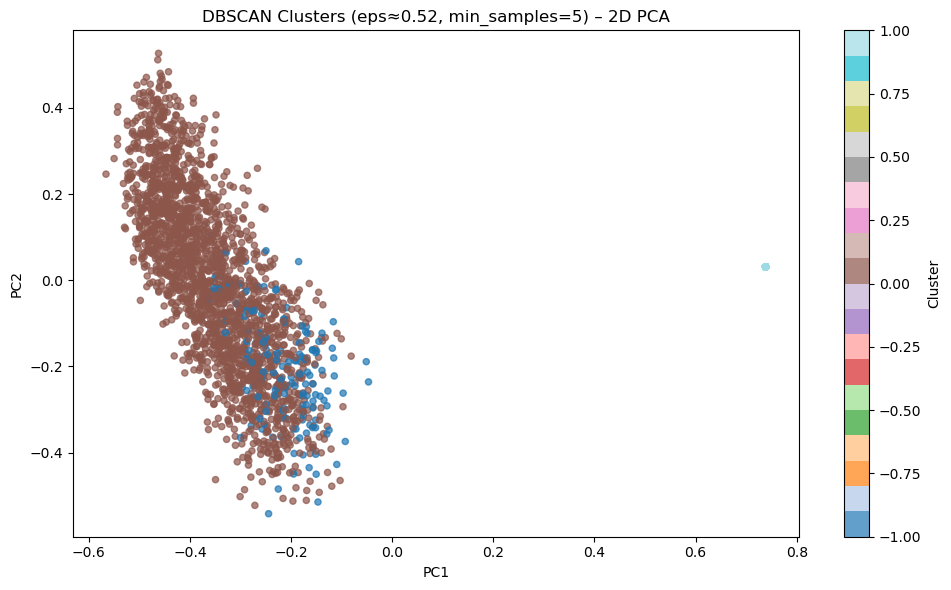

23:00:51 [INFO] Saved cluster_viz_dbscan.png
23:00:51 [INFO] Extracting top terms per cluster via TF-IDF
23:00:56 [INFO] Cluster 0: 2093 documents
23:01:01 [INFO]  → Top terms: quality(0.06), like(0.04), sign(0.04), dev(0.03), testing(0.03), comment(0.03), policy(0.03), ai(0.03), use(0.03), linkedin(0.03)
23:01:01 [INFO] Cluster 1: 1054 documents
23:01:01 [INFO]  → Top terms: 𝐃𝐚𝐭𝐚(0.00), ensuing(0.00), enterprises(0.00), enterprise(0.00), entering(0.00), entered(0.00), enter(0.00), entender(0.00), entails(0.00), entail(0.00)
23:01:01 [INFO] End of DBSCAN clustering pipeline — Memory usage: 960.3 MB


In [47]:
import time
import logging
import psutil
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer

start_time_db =  time.time()

# ── Logging Setup ───────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

def log_memory(msg: str):
    mem = psutil.Process(os.getpid()).memory_info().rss / (1024**2)
    logger.info(f"{msg} — Memory usage: {mem:.1f} MB")

# ── Config ───────────────────────────────────────────────────────────────────────
INPUT_CSV      = "posts_with_test_tools_and_methods_fulltext-v2.csv"
OUTPUT_CSV     = "posts_with_clusters_dbscan.csv"
EMBED_MODEL    = "all-MiniLM-L6-v2"
STOPWORDS      = ENGLISH_STOP_WORDS.union({"big", "data", "test", "tests"})
K_NEIGHBORS    = 5

# ── Load Data ─────────────────────────────────────────────────────────────────────
df = pd.read_csv(INPUT_CSV)
if "Post_Text" not in df.columns:
    raise KeyError(f"Column 'Post_Text' not in {INPUT_CSV}; found: {df.columns.tolist()}")

texts = df["Post_Text"].fillna("").tolist()
logger.info(f"Loaded {len(texts)} documents")
log_memory("After loading data")

# ── Embedding ─────────────────────────────────────────────────────────────────────
model = SentenceTransformer(EMBED_MODEL)
start = time.perf_counter()
embeddings = model.encode(texts, batch_size=32, show_progress_bar=True)
logger.info(f"Embeddings generated in {time.perf_counter()-start:.1f}s")
log_memory("After generating embeddings")

# ── Estimate eps via k-distance ───────────────────────────────────────────────────
logger.info(f"Estimating optimal eps using k-distance graph (k={K_NEIGHBORS})")
neighbors = NearestNeighbors(n_neighbors=K_NEIGHBORS, metric='cosine').fit(embeddings)
distances, _ = neighbors.kneighbors(embeddings)
k_distances = np.sort(distances[:, K_NEIGHBORS - 1])

# plot k-distance graph to inspect "elbow"
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title("k-distance graph (for DBSCAN eps estimation)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{K_NEIGHBORS}th nearest distance (cosine)")
plt.tight_layout()
plt.savefig("k_distance_plot.png")
plt.close()
logger.info("Saved k_distance_plot.png")

# Heuristic: choose distance at 90th percentile
estimated_eps = np.percentile(k_distances, 90)
logger.info(f"Estimated eps at 90th percentile: {estimated_eps:.3f}")

time_DBSCAN = time.time() - start_time_db

# ── DBSCAN Clustering ─────────────────────────────────────────────────────────────
start = time.perf_counter()
dbscan = DBSCAN(eps=estimated_eps, min_samples=K_NEIGHBORS, metric="cosine", n_jobs=-1)
labels = dbscan.fit_predict(embeddings)
elapsed = time.perf_counter() - start

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
logger.info(f"DBSCAN done in {elapsed:.2f}s → {n_clusters} clusters, {n_noise} noise points")
log_memory("After DBSCAN clustering")

# ── Save Results ──────────────────────────────────────────────────────────────────
df["Cluster"] = labels
df.to_csv(OUTPUT_CSV, index=False)
logger.info(f"Clusters saved to {OUTPUT_CSV}")

# ── PCA for 2D Viz ────────────────────────────────────────────────────────────────
start = time.perf_counter()
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(embeddings)
logger.info(f"PCA 2D done in {time.perf_counter()-start:.2f}s")
log_memory("After PCA")

plt.figure(figsize=(10,6))
scatter = plt.scatter(coords[:,0], coords[:,1], c=labels, s=20, cmap="tab20", alpha=0.7)
plt.title(f"DBSCAN Clusters (eps≈{estimated_eps:.2f}, min_samples={K_NEIGHBORS}) – 2D PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.savefig("cluster_viz_dbscan.png")
plt.show()
logger.info("Saved cluster_viz_dbscan.png")

# ── TF-IDF per Cluster ────────────────────────────────────────────────────────────
logger.info("Extracting top terms per cluster via TF-IDF")
vectorizer = TfidfVectorizer(
    stop_words=list(STOPWORDS),
    max_df=0.8,
    min_df=5
)
corpus = df["Post_Text"].fillna("").tolist()
tfidf = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

cluster_docs = (
    df[df["Cluster"] != -1]  # Remove outliers
      .assign(Post_Text=df["Post_Text"].fillna(""))
      .groupby("Cluster")["Post_Text"]
      .agg(list)
)

for c, texts_in_c in cluster_docs.items():
    logger.info(f"Cluster {c}: {len(texts_in_c)} documents")
    tfidf_c = vectorizer.transform(texts_in_c)
    avg_scores = tfidf_c.mean(axis=0).A1
    top_idxs = avg_scores.argsort()[::-1][:10]
    top_terms = [feature_names[i] for i in top_idxs]
    top_scores = avg_scores[top_idxs]
    logger.info(f" → Top terms: " + ", ".join(f"{t}({s:.2f})" for t,s in zip(top_terms, top_scores)))

log_memory("End of DBSCAN clustering pipeline")
print("Processing time (s) = %3.3f s" % (time_DBSCAN))


# LDA

23:54:28 [INFO] Loaded 3301 documents
23:54:28 [INFO] After loading data — Memory usage: 964.1 MB
23:54:37 [INFO] Text preprocessing complete
23:54:37 [INFO] After preprocessing — Memory usage: 966.6 MB
23:54:49 [INFO] Count matrix shape: (3301, 36159)
23:54:49 [INFO] After vectorization — Memory usage: 1156.5 MB
23:56:05 [INFO] LDA fitted in 76.44s
23:56:05 [INFO] After LDA — Memory usage: 1166.7 MB
23:56:06 [INFO] LDA topics saved to posts_with_lda_20_topics.csv
23:56:06 [INFO] Topic 0: google cloud(232.04), best practices(153.55), cloud storage(109.62), testing tools(99.69), testing process(97.43), version control(86.39), automation testing(77.80), automated testing(74.88), google cloud storage(59.11), production environment(51.71)
23:56:06 [INFO] Topic 1: code review(134.44), image author(66.43), machine learning(45.66), vector databases(43.26), code reviews(41.84), pair programming(39.37), engineer things(35.05), delta lake(34.70), privacy rules(32.44), listen share(31.82)
23:56:0

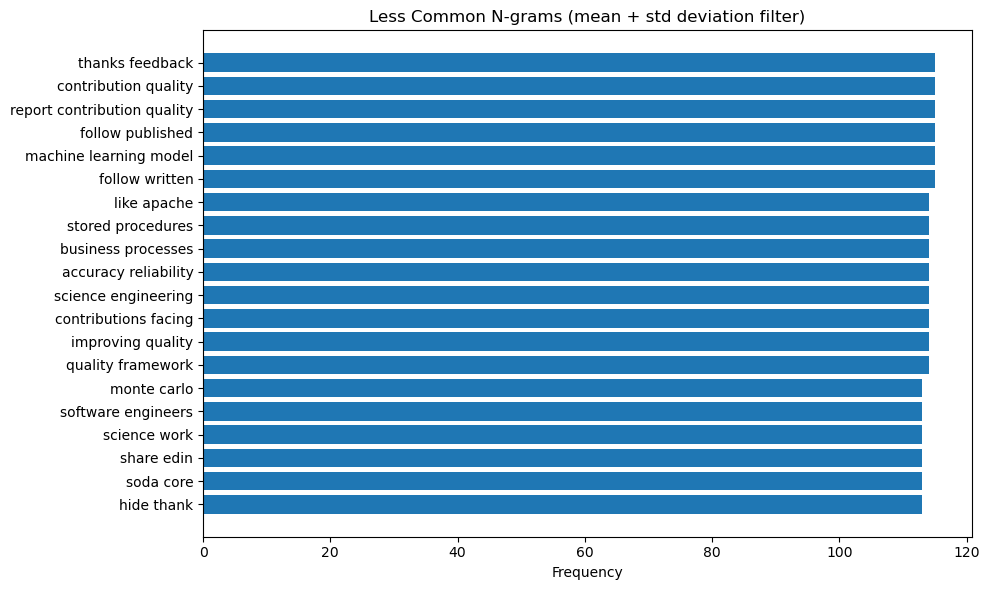

23:56:07 [INFO] Saved lda20_outlier_terms.png
23:56:07 [INFO] End of LDA pipeline — Memory usage: 1168.9 MB


In [59]:
import time
import logging
import psutil
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize

# ── Logging Setup ───────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

def log_memory(msg: str):
    mem = psutil.Process(os.getpid()).memory_info().rss / (1024**2)
    logger.info(f"{msg} — Memory usage: {mem:.1f} MB")

# ── Config ───────────────────────────────────────────────────────────────────────
INPUT_CSV       = "posts_with_test_tools_and_methods_fulltext-v2.csv"
OUTPUT_CSV      = "posts_with_lda_20_topics.csv"
NUM_TOPICS      = 20
TOP_TERMS       = 10
NGRAM_RANGE     = (2, 3)
STOPWORDS       = ENGLISH_STOP_WORDS.union({"big", "data", "test", "tests", "using", "used", "based", "approach"})

# ── Load Data ─────────────────────────────────────────────────────────────────────
df = pd.read_csv(INPUT_CSV)
if "Post_Text" not in df.columns:
    raise KeyError(f"Column 'Post_Text' not in {INPUT_CSV}; found: {df.columns.tolist()}")

texts = df["Post_Text"].fillna("").tolist()
logger.info(f"Loaded {len(texts)} documents")
log_memory("After loading data")

# ── Preprocess Text ───────────────────────────────────────────────────────────────
CUSTOM_PHRASES_TO_REMOVE = [
    "copy link", "fullscreen mode", "create account", "cookie policy",
    "privacy policy", "user agreement", "dropdown menu", "report abuse",
    "sign sign", "comment like", "like comment", "read comment", "menu copy",
    "joined 2022", "linkedin join", "sign welcome", "clicking continue"
]

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove links
    text = re.sub(r"\b\w{1,3}\b", "", text)  # remove short words
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)  # normalize whitespace

    # remove custom phrases
    for phrase in CUSTOM_PHRASES_TO_REMOVE:
        text = text.replace(phrase, "")
    
    # remove duplicated consecutive words (e.g., "sign sign")
    text = re.sub(r"\b(\w+)( \1\b)+", r"\1", text)
    
    return text.strip()

cleaned_texts = [preprocess(t) for t in texts]
logger.info("Text preprocessing complete")
log_memory("After preprocessing")

# ── Count Vectorization with N-Grams ─────────────────────────────────────────────
vectorizer = CountVectorizer(
    stop_words=list(STOPWORDS),
    ngram_range=NGRAM_RANGE,
    max_df=0.85,
    min_df=5
)
X = vectorizer.fit_transform(cleaned_texts)
logger.info(f"Count matrix shape: {X.shape}")
log_memory("After vectorization")

# ── LDA Topic Modeling ───────────────────────────────────────────────────────────
start = time.perf_counter()
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, random_state=42, learning_method="batch")
doc_topics = lda.fit_transform(X)
elapsed = time.perf_counter() - start
logger.info(f"LDA fitted in {elapsed:.2f}s")
log_memory("After LDA")

# ── Assign Most Probable Topic ───────────────────────────────────────────────────
df["LDA_Topic"] = doc_topics.argmax(axis=1)
df.to_csv(OUTPUT_CSV, index=False)
logger.info(f"LDA topics saved to {OUTPUT_CSV}")

# ── Show Top Terms Per Topic ─────────────────────────────────────────────────────
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_idx = topic.argsort()[::-1][:TOP_TERMS]
    top_words = [feature_names[i] for i in top_idx]
    top_scores = topic[top_idx]
    logger.info(f"Topic {topic_idx}: " + ", ".join(f"{t}({s:.2f})" for t, s in zip(top_words, top_scores)))

# ── Visualization: Term Frequencies (std dev outliers) ───────────────────────────
term_freq = np.asarray(X.sum(axis=0)).flatten()
mean_freq = term_freq.mean()
std_freq = term_freq.std()
low_freq_mask = (term_freq > 0) & (term_freq < mean_freq + std_freq)

low_freq_terms = np.array(feature_names)[low_freq_mask]
low_freq_counts = term_freq[low_freq_mask]

top_outliers_idx = low_freq_counts.argsort()[::-1][:20]
top_outlier_terms = low_freq_terms[top_outliers_idx]
top_outlier_counts = low_freq_counts[top_outliers_idx]

plt.figure(figsize=(10,6))
plt.barh(top_outlier_terms[::-1], top_outlier_counts[::-1])
plt.xlabel("Frequency")
plt.title("Less Common N-grams (mean + std deviation filter)")
plt.tight_layout()
plt.savefig("lda_outlier_terms.png")
plt.show()
logger.info("Saved lda20_outlier_terms.png")

log_memory("End of LDA pipeline")


23:54:28 [INFO] Loaded 3301 documents
23:54:28 [INFO] After loading data — Memory usage: 964.1 MB
23:54:37 [INFO] Text preprocessing complete
23:54:37 [INFO] After preprocessing — Memory usage: 966.6 MB
23:54:49 [INFO] Count matrix shape: (3301, 36159)
23:54:49 [INFO] After vectorization — Memory usage: 1156.5 MB
23:56:05 [INFO] LDA fitted in 76.44s
23:56:05 [INFO] After LDA — Memory usage: 1166.7 MB
23:56:06 [INFO] LDA topics saved to posts_with_lda_20_topics.csv
23:56:06 [INFO] Topic 0: google cloud(232.04), best practices(153.55), cloud storage(109.62), testing tools(99.69), testing process(97.43), version control(86.39), automation testing(77.80), automated testing(74.88), google cloud storage(59.11), production environment(51.71)
23:56:06 [INFO] Topic 1: code review(134.44), image author(66.43), machine learning(45.66), vector databases(43.26), code reviews(41.84), pair programming(39.37), engineer things(35.05), delta lake(34.70), privacy rules(32.44), listen share(31.82)
23:56:06 [INFO] Topic 2: clear text(410.46), join sign(373.10), sign agree(320.54), agree linkedin(320.39), sign agree linkedin(320.08), join sign agree(320.06), text clear text(244.95), clear text clear(244.86), text clear(244.38), linkedin join sign(184.15)
23:56:06 [INFO] Topic 3: machine learning(2265.25), artificial intelligence(759.24), deep learning(545.34), text speech(273.08), followers following(272.48), responses help(272.14), responses help status(272.13), logo write(271.80), sitemap open(271.80), medium logo(271.80)
23:56:06 [INFO] Topic 4: sitemap open(569.21), logo write(569.20), open medium logo(569.20), sitemap open medium(569.20), medium logo(569.20), medium logo write(569.20), open medium(569.19), text speech(567.79), terms text(566.84), privacy rules terms(566.83)
23:56:06 [INFO] Topic 5: reactions comments(157.29), comments comment(94.05), comments comment read(94.05), comment read(94.05), comments read(87.03), reactions comments read(86.05), reactions comments comment(69.05), machine intelligence(52.74), supply chain(34.41), intelligence community(34.03)
23:56:06 [INFO] Topic 6: collapse expand(2243.11), button reply(2237.15), like button(2169.48), like button reply(2167.93), button reply collapse(1988.16), reply collapse(1988.16), reply collapse expand(1988.15), joined 2019(746.57), software engineer(607.60), joined 2019 hide(583.80)
23:56:06 [INFO] Topic 7: machine learning(113.56), open source(68.40), apache hadoop(56.69), apache spark(39.70), hadoop cluster(39.62), business intelligence(39.59), distributed file(33.12), unit testing(31.57), hadoop distributed(29.96), batch processing(29.37)
23:56:06 [INFO] Topic 8: report post(90.20), share edin(89.13), share edin facebook(89.13), facebook twitter view(85.55), twitter view comment(85.55), twitter view(85.41), digital transformation(56.20), azure synapse(52.74), facebook twitter(47.13), azure factory(45.98)
23:56:06 [INFO] Topic 9: analyst jobs(152.63), quality analyst(74.81), anomaly detection(38.83), specialist jobs(25.85), jobs management(25.05), engineer jobs(22.88), cloud engineering(20.46), librarian jobs(20.20), quality analyst jobs(19.39), google cloud(16.94)
23:56:06 [INFO] Topic 10: enter exit(2047.15), diamond sponsors(808.65), code conduct(801.64), open source(487.20), ruby rails(430.32), software development(410.17), user create(409.73), stay date(407.14), navigation menu(406.58), rails community(406.48)
23:56:06 [INFO] Topic 11: machine learning(270.72), code conduct(168.43), diamond sponsors(167.70), software development(155.57), open source(137.50), best practices(101.28), enter exit(96.42), stay date(88.09), software powers(85.72), user create(85.54)
23:56:06 [INFO] Topic 12: join sign(1426.52), join sign agree(956.58), agree linkedin(956.52), sign agree(956.42), sign agree linkedin(956.37), like reply(849.71), report comment(844.69), reply reaction(726.42), like reply reaction(716.62), edin facebook(511.07)
23:56:06 [INFO] Topic 13: github actions(159.10), tools like(87.06), performance testing(79.69), quality testing(65.27), like apache(58.10), batch processing(57.81), integration testing(52.15), tools like apache(43.56), apache spark(41.59), regression testing(36.86)
23:56:06 [INFO] Topic 14: software testing(180.25), open source(83.62), source target(73.19), software development(69.68), stream processing(68.30), listen share(65.48), followers following(63.38), blog privacy(62.99), help status(62.99), careers press blog(62.99)
23:56:06 [INFO] Topic 15: great expectations(609.86), quality issues(302.17), quality checks(288.47), quality management(193.13), missing values(189.07), quality metrics(134.99), monte carlo(100.21), ensuring quality(97.50), null values(95.28), quality monitoring(85.28)
23:56:06 [INFO] Topic 16: quality assurance(472.76), engineer jobs(469.52), jobs software(176.78), jobs quality(165.93), assurance engineer(163.05), quality assurance engineer(162.05), analyst jobs(160.09), software quality(157.99), jobs senior(138.33), assurance engineer jobs(127.05)
23:56:06 [INFO] Topic 17: apache spark(353.35), unit testing(123.31), spark streaming(88.24), spark applications(52.95), best practices(48.65), spark application(48.38), change capture(48.04), comprehensive guide(47.48), apache hive(40.83), spark cluster(37.82)
23:56:06 [INFO] Topic 18: frank rosner(369.05), rosner frank(209.05), frank rosner frank(209.05), rosner frank rosner(206.05), machine learning(172.80), software development(134.25), rosner follow(121.05), frank rosner follow(121.05), lambda function(98.59), source code(92.11)
23:56:06 [INFO] Topic 19: contribution report(2172.69), contribution report contribution(2171.74), report contribution(2171.57), perspective help(629.51), help sharing characters(628.62), characters cancel(628.54), sharing characters cancel(628.51), perspective help sharing(628.46), characters cancel save(628.39), help sharing(628.26)

# FILTRANDO OS CLUSTERS OS TOPICS

In [3]:
import pandas as pd

# Caminho do arquivo original gerado pelo LDA
# INPUT_CSV = "posts_with_lda_20_topics.csv"
# OUTPUT_CSV = "LDA_topic_17_filtered.csv"

# INPUT_CSV = "posts_with_clusters.csv"
# OUTPUT_CSV = "KMEANS_cluster_12_filtered.csv"

INPUT_CSV = "posts_with_clusters_BKMEANS.csv"
OUTPUT_CSV = "BKMEANS_cluster_1_filtered.csv"

# INPUT_CSV = "posts_with_clusters_dbscan.csv"
# OUTPUT_CSV = "DBSCAN_cluster_-1_filtered.csv"

# Carregar o arquivo
df = pd.read_csv(INPUT_CSV)

# Filtrar pelo tópico desejado
# filtered_df = df[df["LDA_Topic"] == 17]
# filtered_df = df[df["Cluster"] == 12]
filtered_df = df[df["Cluster"] == 1]


# Salvar resultado
filtered_df.to_csv(OUTPUT_CSV, index=False)

print(f"{len(filtered_df)} linhas salvas em {OUTPUT_CSV}")


517 linhas salvas em BKMEANS_cluster_1_filtered.csv


## LDA com Coerência de Tópicos (Topic Coherence)

In [55]:
pip install gensim scikit-learn pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


23:30:46 [INFO] adding document #0 to Dictionary<0 unique tokens: []>
23:30:48 [INFO] built Dictionary<83319 unique tokens: ['0004', '2016', '2024', '2025', '9999']...> from 2247 documents (total 2083900 corpus positions)
23:30:48 [INFO] Dictionary lifecycle event {'msg': "built Dictionary<83319 unique tokens: ['0004', '2016', '2024', '2025', '9999']...> from 2247 documents (total 2083900 corpus positions)", 'datetime': '2025-07-02T23:30:48.701940', 'gensim': '4.3.3', 'python': '3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'created'}
23:30:50 [INFO] Iniciando avaliação de coerência para vários k...
23:30:50 [INFO] using symmetric alpha at 0.2
23:30:50 [INFO] using symmetric eta at 0.2
23:30:50 [INFO] using serial LDA version on this node
23:30:50 [INFO] running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 2247 documents, updating model once every 2

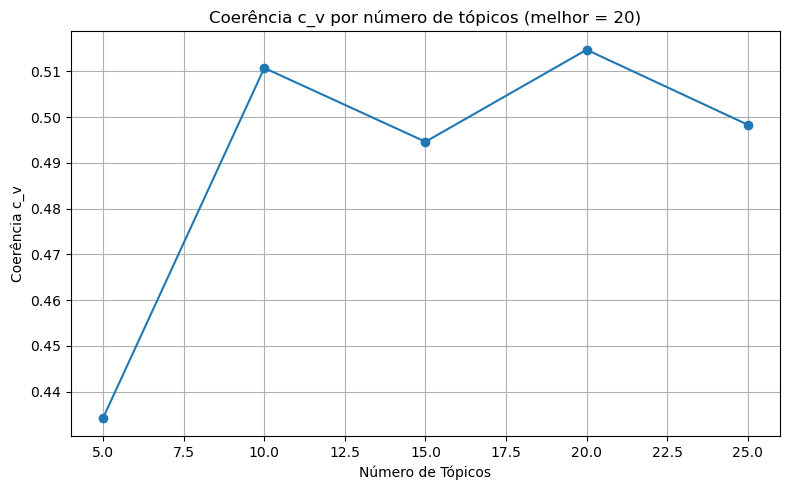

In [57]:
import os
import re
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# ── Logging ─────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)

# ── Config ───────────────────────────────────────────────────────────────
INPUT_CSV = "posts_with_test_tools_and_methods_fulltext-v2.csv"
TEXT_COLUMN = "Post_Text"
CUSTOM_PHRASES_TO_REMOVE = [
    "copy link", "fullscreen mode", "create account", "cookie policy",
    "privacy policy", "user agreement", "dropdown menu", "report abuse",
    "sign sign", "comment like", "like comment", "read comment", "menu copy",
    "joined 2022", "linkedin join", "sign welcome", "clicking continue"
]
STOPWORDS = ENGLISH_STOP_WORDS.union({
    "big", "data", "test", "tests", "using", "used", "based", "approach"
})

# ── Funções de limpeza ──────────────────────────────────────────────────
def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\b\w{1,3}\b", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    for phrase in CUSTOM_PHRASES_TO_REMOVE:
        text = text.replace(phrase, "")
    text = re.sub(r"\b(\w+)( \1\b)+", r"\1", text)  # remove duplicatas consecutivas
    return text.strip()

# ── Carregar e limpar dados ──────────────────────────────────────────────
df = pd.read_csv(INPUT_CSV)
texts = df[TEXT_COLUMN].fillna("").tolist()
cleaned_texts = [preprocess(t) for t in texts]
tokenized_texts = [
    [word for word in text.split() if word not in STOPWORDS]
    for text in cleaned_texts
    if len(text.split()) >= 5
]

# ── Criar dicionário e corpus ────────────────────────────────────────────
id2word = corpora.Dictionary(tokenized_texts)
corpus = [id2word.doc2bow(text) for text in tokenized_texts]

# ── Avaliação de Coerência ───────────────────────────────────────────────
model_list = []
coherence_values = []
topics_range = range(5, 26, 5)

logger.info("Iniciando avaliação de coerência para vários k...")
for num_topics in topics_range:
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        iterations=100
    )
    model_list.append(lda_model)
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=tokenized_texts,
        dictionary=id2word,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    coherence_values.append(coherence)
    logger.info(f"Num topics = {num_topics} → Coherence Score = {coherence:.4f}")

# ── Melhor modelo ────────────────────────────────────────────────────────
best_index = int(np.argmax(coherence_values))
best_k = topics_range[best_index]
best_model = model_list[best_index]

logger.info(f"Melhor número de tópicos: {best_k} com coerência = {coherence_values[best_index]:.4f}")

# ── Salvar gráfico ───────────────────────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.plot(topics_range, coherence_values, marker='o')
plt.title(f"Coerência c_v por número de tópicos (melhor = {best_k})")
plt.xlabel("Número de Tópicos")
plt.ylabel("Coerência c_v")
plt.grid(True)
plt.tight_layout()
plt.savefig("lda_coherence_scores.png")
plt.show()


# SUMARY

In [ ]:
print("====================================================================")
print("=============  Compare Algorithm Silhouette and Time ===============")
print()
print("K-Means:                        silhouette = %3.2f    time = %3.3f s" % (silhouette_km, time_km))
print("Bisecting k-means:              silhouette = %3.2f    time = %3.3f s" % (silhouette_bk, time_bk))
print("DBSCAN:   silhouette = %3.2f    time = %3.3f s" % (silhouette_DBSCAN, time_DBSCAN))
print("====================================================================")

In [ ]:
sc.stop()
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

# verificando posts em comum entre os clusters/topic (kmeans/bkmeans/lda)

In [6]:
import pandas as pd

# Carregar os três arquivos CSV
csv1 = pd.read_csv("KMEANS_cluster_12_filtered.csv")
csv2 = pd.read_csv("BKMEANS_cluster_1_filtered.csv")
csv3 = pd.read_csv("LDA_topic_17_filtered.csv")

# Extrair os conjuntos de links
links1 = set(csv1["Link"].dropna())
links2 = set(csv2["Link"].dropna())
links3 = set(csv3["Link"].dropna())

# Contador de ocorrências de cada link nos três arquivos
from collections import Counter

# Combinar todos os links em uma única lista para contar
all_links = list(links1) + list(links2) + list(links3)
link_counts = Counter(all_links)

# Filtrar os que aparecem em 2 ou mais arquivos
repeated_links = {link for link, count in link_counts.items() if count >= 2}

# Mostrar os resultados
print(f"\nLinks repetidos (em pelo menos 2 dos 3 CSVs):")
for link in sorted(repeated_links):
    print(link)

# Opcional: salvar em um novo arquivo
pd.DataFrame(sorted(repeated_links), columns=["Link"]).to_csv("links_repetidos.csv", index=False)



Links repetidos (em pelo menos 2 dos 3 CSVs):
https://ajithshetty28.medium.com/deequ-i-mean-data-quality-a0e6c048469d
https://anupamchand.medium.com/pyspark-data-frame-quality-validation-framework-in-databricks-using-great-expectations-hands-on-5fd0b070ea09
https://fithis2001.medium.com/adding-some-minio-to-your-standalone-apache-spark-cluster-d068b4f4fdab
https://medium.com/@geekfrosty/pydeequ-testing-data-quality-at-scale-209b674a4259
https://medium.com/@josh.temple/automated-testing-in-the-modern-data-warehouse-d5a251a866af
https://medium.com/@sergey.kotlov/unit-testing-of-spark-applications-cf0162a5cb3c
https://medium.com/@sutherl99/designing-a-shift-left-data-engineering-process-in-gcp-e8eac5fe9a1f
https://medium.com/@sutherl99/implementing-a-shift-left-data-quality-process-in-azure-3f67586999a5
https://medium.com/@wyaddow/maintain-data-quality-with-data-refactoring-tests-f46580d0b43e
https://medium.com/@yjaisingh/data-quality-6e3dec6fb6b
https://medium.com/agile-lab-engineering/